In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from plotnine import *
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering as AggClus
import scipy.cluster.hierarchy as shc
from somlib import som
import SimpSOM as sps
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

SEED = 42

import warnings
warnings.filterwarnings("ignore")

In [327]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Task 2+3 : Data exploration and cleaning

In [61]:
df_train.sample(10)

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
24287       24287  111127    Male     Loyal Customer   59  Business travel   
52074       52074  117064  Female     Loyal Customer   29  Business travel   
96764       96764  121906    Male     Loyal Customer   12  Personal Travel   
34531       34531   48547    Male     Loyal Customer   43  Personal Travel   
82936       82936   45277    Male     Loyal Customer   34  Business travel   
27868       27868  108373    Male     Loyal Customer   49  Personal Travel   
63491       63491  114842  Female  disloyal Customer   35  Business travel   
78673       78673   28887  Female     Loyal Customer   23  Business travel   
43033       43033    6239    Male     Loyal Customer   72  Business travel   
90425       90425    8125    Male  disloyal Customer   33  Business travel   

          Class  Flight Distance  Inflight wifi service  \
24287  Business             3648                      5   
52074  Business             2307                      2   
96764       Eco              366                      3   
34531       Eco              819                      2   
82936       Eco              222                      4   
27868       Eco             1855                      3   
63491  Business              342                      2   
78673  Business             2291                      5   
43033       Eco              594                      3   
90425  Business              335                      4   

       Departure/Arrival time convenient  ...  Inflight entertainment  \
24287                                  5  ...                       4   
52074                                  2  ...                       3   
96764                                  4  ...                       1   
34531                                  2  ...                       5   
82936                                  2  ...                       4   
27868                                  4  ...                       3   
63491                                  2  ...                       5   
78673                                  5  ...                       5   
43033                                  4  ...                       3   
90425                                  4  ...                       4   

       On-board service  Leg room service  Baggage handling  Checkin service  \
24287                 4                 5                 4                4   
52074                 3                 5                 5                3   
96764                 4                 3                 5                5   
34531                 1                 5                 2                3   
82936                 4                 1                 4                3   
27868                 5                 3                 3                4   
63491                 5                 4                 4                5   
78673                 3                 3                 4                5   
43033                 1                 1                 4                1   
90425                 5                 5                 5                5   

       Inflight service  Cleanliness  Departure Delay in Minutes  \
24287                 4            4                          32   
52074                 4            3                           8   
96764                 5            1                           0   
34531                 2            5                           0   
82936                 2            4                           0   
27868                 4            4                         165   
63491                 4            5                          18   
78673                 5            5                          98   
43033                 4            3                           0   
90425                 4            4                           0   

       Arrival Delay in Minutes             satisfaction  
24287

**Handling spaces in the columns names for convinience :**

In [328]:
df_train.columns=[each.replace(" ","_") for each in df_train.columns]
df_test.columns=[each.replace(" ","_") for each in df_test.columns]

**Brief analysis of the column data types and variables types**

In [329]:
df_train.info()
md(
    f"**Categorical Variables:** <br>"
    f"Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Checkin service, Inflight service, Cleanliness,Gender, Customer Type, Type of Travel, Class and satisfaction.<br>"
    f"<br>"
    f"**Numerical Variables:**<br>" 
    f"id,Age, Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes"
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed:_0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer_Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type_of_Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight_Distance                    103904 non-null  int64  
 8   Inflight_wifi_service              103904 non-null  int64  
 9   Departure/Arrival_time_convenient  103904 non-null  int64  
 10  Ease_of_Online_booking             103904 non-null  int64  
 11  Gate_location                      1039

**Categorical Variables:** <br>Inflight wifi service, Departure/Arrival time convenient, Ease of Online booking, Gate location, Food and drink, Online boarding, Seat comfort, Inflight entertainment, On-board service, Leg room service, Baggage handling, Checkin service, Inflight service, Cleanliness,Gender, Customer Type, Type of Travel, Class and satisfaction.<br><br>**Numerical Variables:**<br>id,Age, Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes

**Dropping 'Unnamed: 0' and 'id' columns: (they will not be usable for our analysis)**


In [330]:
df_train.drop(['Unnamed:_0','id'],axis='columns', inplace=True)
df_test.drop(['Unnamed:_0','id'],axis='columns', inplace=True)

**Encoding Categorial (nominal) features (to enable correlation analysis):**

In [331]:
encoded_categories = {"Gender":     {"Male": 0, "Female": 1},
                    "Customer_Type": {"Loyal Customer": 0, "disloyal Customer": 1},
                    "Type_of_Travel": {"Personal Travel": 0, "Business travel": 1},
                    "Class": {"Eco": 0, "Eco Plus": 1,"Business": 2},
                    "satisfaction": {"neutral or dissatisfied": 0, "satisfied": 1}                   
                   }
df_train = df_train.replace(encoded_categories)
df_test = df_test.replace(encoded_categories)

df_train.tail(20)

Gender  Customer_Type  Age  Type_of_Travel  Class  Flight_Distance  \
103884       1              0   19               0      0              334   
103885       0              0   40               1      2              500   
103886       0              1   36               1      2             2556   
103887       1              0   51               0      0             1222   
103888       0              1   38               1      2              447   
103889       1              0   43               1      2             3885   
103890       1              0   56               1      1              550   
103891       0              0   54               1      2             1991   
103892       1              1   37               1      2              596   
103893       1              0   58               1      2              296   
103894       0              0   26               1      2              712   
103895       1              1   24               1      0             1055   
103896       0              0   57               1      0              867   
103897       1              0   60               1      2             1599   
103898       0              0   50               0      0             1620   
103899       1              1   23               1      0              192   
103900       0              0   49               1      2             2347   
103901       0              1   30               1      2             1995   
103902       1              1   22               1      0             1000   
103903       0              0   27               1      2             1723   

        Inflight_wifi_service  Departure/Arrival_time_convenient  \
103884                      2                                  5   
103885                      4                                  4   
103886                      3                                  3   
103887                      5                                  4   
103888                      2                                  2   
103889                      5                                  5   
103890                      3                                  5   
103891                      5                                  5   
103892                      3                                  3   
103893                      3                                  3   
103894                      4                                  4   
103895                      1                                  1   
103896                      4                                  5   
103897                      5                                  5   
103898                      3                                  1   
103899                      2                                  1   
103900                      4                                  4   
103901                      1                                  1   
103902                      1                                  1   
103903                      1                                  3   

        Ease_of_Online_booking  Gate_location  ...  Inflight_entertainment  \
103884                       2              1  ...                       5   
103885                       4              4  ...                       3   
103886                       3              1  ...                       5   
103887                       5              4  ...                       3   
103888                       2              4  ...                       3   
103889                       5              5  ...                       3   
103890                       5              5  ...                       3   
103891                       5              5  ...                       4   
103892                       3              4  ...                       3   
103893                       5              3  ...                       3   
103894                       4              4  ...                       5   
1038

**We will group the features according to their variable types:**

In [332]:
category_ordinal=["Inflight_wifi_service", "Departure/Arrival_time_convenient", "Ease_of_Online_booking", "Gate_location", "Food_and_drink", "Online_boarding", "Seat_comfort", "Inflight_entertainment", "On-board_service", "Leg_room_service", "Baggage_handling", "Checkin_service", "Inflight_service", "Cleanliness","Class"]
category_nominal=["Gender", "Customer_Type", "Type_of_Travel"]
numericVar=["Age", "Flight_Distance", "Departure_Delay_in_Minutes"]

# We considered the type of the "Class" feature as ordinal (Eco = 0 < Eco plus = 1 < Business = 2)

**Since the nominal categorial features cannot be included in the correlation matrix as the numeric & ordinal features, we will changes their type to categorial - which will exclude them from the correlation matrix which will be displated below**

In [333]:
for cat in category_nominal:
    df_train[cat] = df_train[cat].astype(pd.api.types.CategoricalDtype())

In [68]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             103904 non-null  category
 1   Customer_Type                      103904 non-null  category
 2   Age                                103904 non-null  int64   
 3   Type_of_Travel                     103904 non-null  category
 4   Class                              103904 non-null  int64   
 5   Flight_Distance                    103904 non-null  int64   
 6   Inflight_wifi_service              103904 non-null  int64   
 7   Departure/Arrival_time_convenient  103904 non-null  int64   
 8   Ease_of_Online_booking             103904 non-null  int64   
 9   Gate_location                      103904 non-null  int64   
 10  Food_and_drink                     103904 non-null  int64   
 11  Online_boarding           

***Checking for missing values (Nulls)***

In [12]:
df_train.isnull().sum()

Gender                                 0
Customer_Type                          0
Age                                    0
Type_of_Travel                         0
Class                                  0
Flight_Distance                        0
Inflight_wifi_service                  0
Departure/Arrival_time_convenient      0
Ease_of_Online_booking                 0
Gate_location                          0
Food_and_drink                         0
Online_boarding                        0
Seat_comfort                           0
Inflight_entertainment                 0
On-board_service                       0
Leg_room_service                       0
Baggage_handling                       0
Checkin_service                        0
Inflight_service                       0
Cleanliness                            0
Departure_Delay_in_Minutes             0
Arrival_Delay_in_Minutes             310
satisfaction                           0
dtype: int64

**We noticed that Arrival Delay in Minutes is the only columns with nulls.<br>
We will handle the missing values using imputaion - assigning mean value.**


In [13]:
df_train["Arrival_Delay_in_Minutes"]=df_train["Arrival_Delay_in_Minutes"].fillna(np.mean(df_train["Arrival_Delay_in_Minutes"]))

**After remvoing the missing values, we verify that no missing values remain in Arrival_Delay_in_Minutes**

In [14]:
df_train['Arrival_Delay_in_Minutes'].isnull().sum()

0

Text(0.5, 1.0, 'Feature Correlation Matrix')

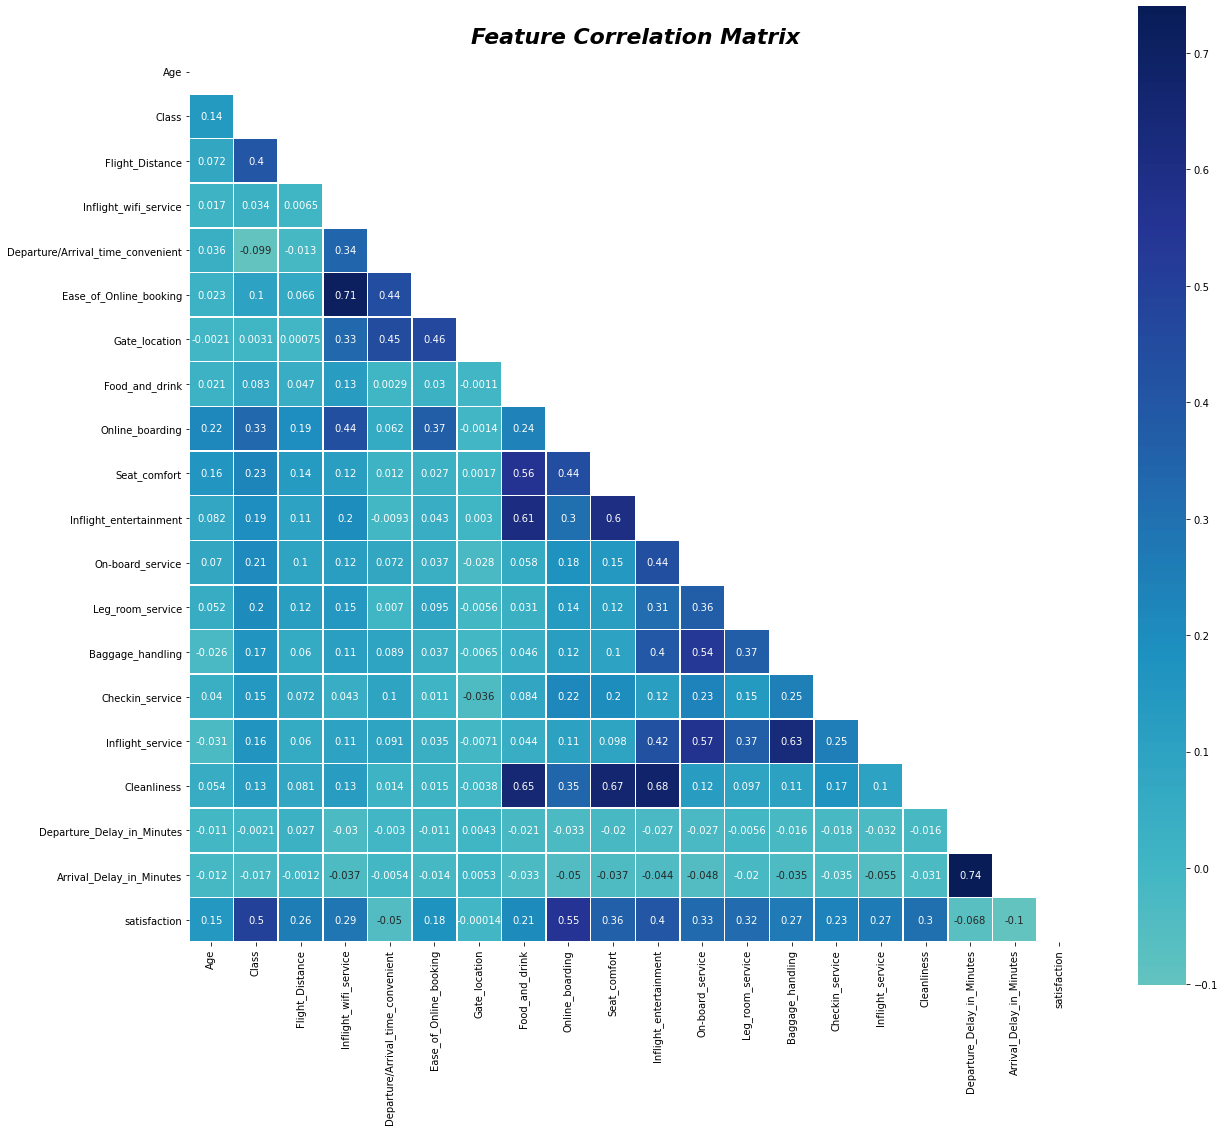

In [72]:
corr = df_train.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)
plt.title('Feature Correlation Matrix', fontweight='bold',style= 'italic',size=22)

**Correlations analysis:**

Correlation coefficients whose magnitude are between 0.5 and 0.7 indicate variables which can be considered moderately correlated.<br> Correlation coefficients whose magnitude are between 0.3 and 0.5 indicate variables which have a low correlation

1. High correlation was found between 2 pairs of features -<br> 
    * Departure_Delay_in_Minutes & Arrival_Delay_in_Minutes
    * Ease_of_Online_booking & Inflight_wifi_service<br>
  *We will investigate these correlations further below.*
  

2. As our research question is related to satisfaction,<br> we examine the features with the best correlations to it, we
   notice that the best correlation are received for:
    * Online_boarding
    * Class <br>
    (However, even for these features, the correlation values are quite average only).
  
***Possible explanation:***<br>
- Departure Delay direclty causes Arrival Delay so the high correlation is obvious.
- We assume that people who booked online and considered this important, will naturally consider Wifi service during flight   as important too (probably technological people)

**1. We again verify that the 3 features with best correlations are:**<br>    - Online_boarding<br>    - Class<br>    - Inflight_entertainment<br>**2. Gender and Gate Location have the least correlation with satisfaction,<br>  we will keep that in mind while continuing our invesigation**<br>

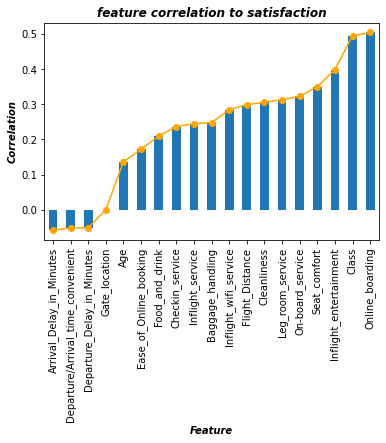

In [334]:
corr = df_train.corr()['satisfaction'].drop('satisfaction').sort_values()

cor=df_train.corr()['satisfaction'].sort_values().drop('satisfaction').plot(kind='bar')
plt.title('feature correlation to satisfaction', fontweight='bold',style= 'italic')
plt.xlabel('Feature',fontweight='bold',style= 'italic' )
plt.ylabel('Correlation',fontweight='bold',style= 'italic' )
plt.plot(df_train.columns.drop(['satisfaction','Gender','Customer_Type','Type_of_Travel']),corr.values , '-o', color='orange')
md(
    f"**1. We again verify that the 3 features with best correlations are:**<br>"
    f"    - Online_boarding<br>"
    f"    - Class<br>"
    f"    - Inflight_entertainment<br>"
    f"**2. Gender and Gate Location have the least correlation with satisfaction,<br>"
    f"  we will keep that in mind while continuing our invesigation**<br>"
)

**Categorial (nominal) features analysis - using the Chi square test:**<br>
Since the analysis of correlation matrix which uses Spearmon coefficient is not suitable for nominal categorial features 
(only for continous numeric and ordinal categorial variables) - we will analyze the categorial (nominal) using Chi Squeare test:

* **First, We have to prepare the data into a contingency table (crosstab), on which the Chi Square test will be  performed.**<br>
For that purpose, we will use One-Hot encoding to transorm the statisfaction categories into seperate clomumns**

In [336]:
df_sat = pd.get_dummies(df_train['satisfaction'],prefix='satisfaction')
df_gen_sat = pd.concat([df_sat, df_train['Gender']], axis=1)
df_gen_sat.sample(5)

satisfaction_0  satisfaction_1 Gender
39779               1               0      1
432                 1               0      1
86010               1               0      0
91589               1               0      0
72109               1               0      1

In [337]:
cross_gen_sat = pd.crosstab(df_gen_sat['Gender'],[df_gen_sat['satisfaction_0'],df_gen_sat['satisfaction_1']])

males_data = list(cross_gen_sat.loc[0])
females_data = list(cross_gen_sat.loc[1])


cross_gen_sat

satisfaction_0      0      1
satisfaction_1      1      0
Gender                      
0               22491  28686
1               22534  30193

* **Next, we perform the Chi Square test to check dependency between categorial variables Gender & Satisfaction:**<br>
  **(H0)** - null hypothesis: there is no relation between the variables.<br>
  **(H1)** - alternate hypothesis: there is a significant relation between the two variables.

In [338]:
data = [males_data, females_data]
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

md(
    f"**Conclusion: Gender & Satisfacation are dependent variables:** <br>"
)    

p value is 8.496755458033522e-05
Dependent (reject H0)


**Conclusion: Gender & Satisfacation are dependent variables:** <br>

**Another (quicker analysis of the Gender Vs Satisfaction)**

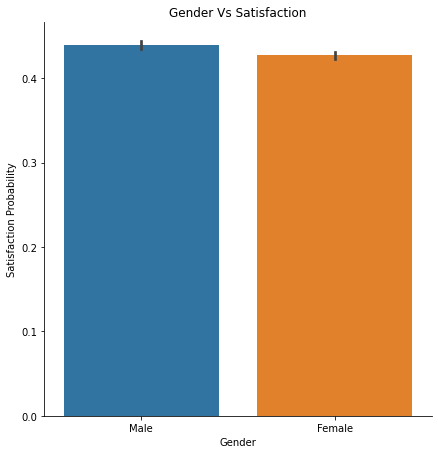

In [77]:
g=sns.catplot(x="Gender",y="satisfaction",data=df_train,kind="bar",size=6)
g.set_ylabels("Satisfaction Probability")
plt.title('Gender Vs Satisfaction')
g.set_xticklabels(['Male','Female'])
plt.show()



In [78]:
df_gender = df_train[["Gender","satisfaction"]].groupby(["Gender"],as_index=False).mean().sort_values(by="satisfaction",ascending=False)
df_gender

Gender  satisfaction
0      0      0.439475
1      1      0.427371

**44% of the males and 43% of the females are satisfied, indicating there is no obvious relationship between them.**

**Chi Square test for depdency check between Customer type & Satisfaction:**
 * First, We prepare the data in a contingency table (crosstab)

In [339]:
df_sat = pd.get_dummies(df_train['satisfaction'],prefix='satisfaction')
df_cust_sat = pd.concat([df_sat, df_train['Customer_Type']], axis=1)

df_cust_sat = pd.crosstab(df_cust_sat['Customer_Type'],[df_cust_sat['satisfaction_0'],df_cust_sat['satisfaction_1']])

loyal_cusotmers = list(df_cust_sat.loc[0])
disloyal_cusotmers = list(df_cust_sat.loc[1])

df_cust_sat

satisfaction_0      0      1
satisfaction_1      1      0
Customer_Type               
0               40533  44390
1                4492  14489

* **Next, we perform the Chi Square test to check dependency between categorial variables Customer Type & Satisfaction:**<br>

In [340]:
data = [loyal_cusotmers, disloyal_cusotmers]
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

md(
    f"**Conclusion: Customer Type & Satisfacation are dependent variables:** <br>"
)   

p value is 0.0
Dependent (reject H0)


**Conclusion: Customer Type & Satisfacation are dependent variables:** <br>

**Another (quicker analysis of the Customer Type Vs Satisfaction)**

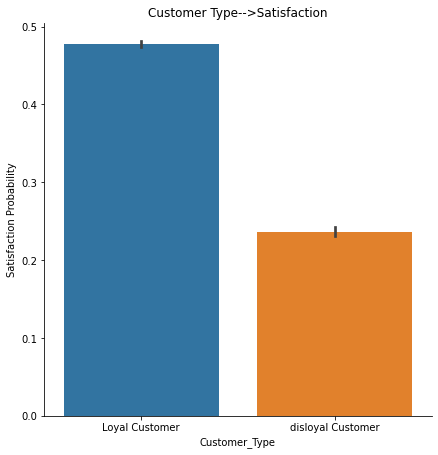

In [81]:
g=sns.factorplot(x="Customer_Type",y="satisfaction",data=df_train,kind="bar",size=6)
g.set_ylabels("Satisfaction Probability")
plt.title('Customer Type-->Satisfaction')
g.set_xticklabels(['Loyal Customer','disloyal Customer'])
plt.show()
                   

**From the diagram, we can clearly see that loyal customers are more satisfied than disloyal customers, this also indicates that this feature could be important for our analysis.**

**Chi Square test for depdency check between Type of Travel & Satisfaction:**
 * First, We prepare the data in a contingency table (crosstab)

In [342]:
df_sat = pd.get_dummies(df_train['satisfaction'],prefix='satisfaction')
df_travel_sat = pd.concat([df_sat, df_train['Type_of_Travel']], axis=1)

df_travel_sat = pd.crosstab(df_travel_sat['Type_of_Travel'],[df_travel_sat['satisfaction_0'],df_travel_sat['satisfaction_1']])

personal_travel = list(df_cust_sat.loc[0])
business_travel = list(df_cust_sat.loc[1])

df_travel_sat

satisfaction_0      0      1
satisfaction_1      1      0
Type_of_Travel              
0                3279  28970
1               41746  29909

* **Next, we perform the Chi Square test to check dependency between categorial variables Type of Travel & Satisfaction:**<br>

In [343]:
data = [personal_travel, business_travel]
stat, p, dof, expected = chi2_contingency(data)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

md(
    f"**Conclusion: Gender & Satisfacation are dependent variables:** <br>"
)    

p value is 0.0
Dependent (reject H0)


**Conclusion: Gender & Satisfacation are dependent variables:** <br>

**Another (quicker analysis of the Type of Travel Vs Satisfaction)**

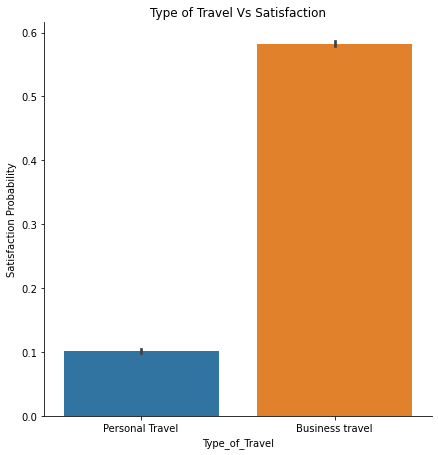

In [84]:
g=sns.factorplot(x="Type_of_Travel",y="satisfaction",data=df_train,kind="bar",size=6)
g.set_ylabels("Satisfaction Probability")
plt.title('Type of Travel Vs Satisfaction')
g.set_xticklabels(['Personal Travel','Business travel'])
plt.show()


**From the diagram, we can clearly see that passengers in Business travel are more satisfied than in Personal travel, this also indicates that this feature could be important for our analysis.**

**Another (quicker analysis of the Class Vs Satisfaction)**

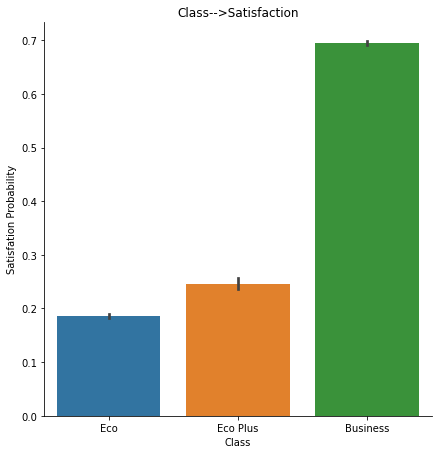

In [85]:
g=sns.factorplot(x="Class",y="satisfaction",data=df_train,kind="bar",size=6)
g.set_ylabels("Satisfation Probability")
plt.title('Class-->Satisfaction')
g.set_xticklabels(['Eco','Eco Plus','Business'])
plt.show()

**From the diagram, we can clearly see that as the class is more exclusive, the more satisfied are the passgengers, this also indicates that this feature could be important for our analysis.**

**In the next visualization, we examine the most correlated features from the correlation matrix.**

Text(0.5, 1.0, 'Examiniation of the 2 highly correlated features')

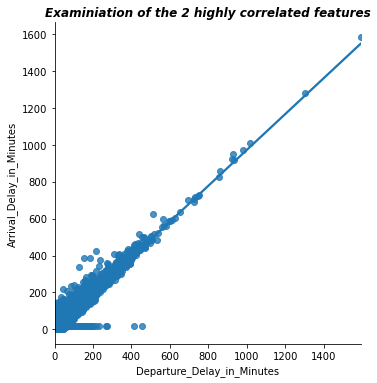

In [86]:
sns.lmplot(x='Departure_Delay_in_Minutes',y='Arrival_Delay_in_Minutes',data=df_train)
plt.title('Examiniation of the 2 highly correlated features',fontweight='bold',style= 'italic')

We see there is a strong linear correlation between these 2 features,<br>
so we decide to remove Arrival_Delay_in_Minutes as it initially included many null values,<br>
also after the imputation we performed, we don't consider this feature as very reliable for the analysis


In [344]:
df_train.drop('Arrival_Delay_in_Minutes',axis=1,inplace=True)
df_test.drop('Arrival_Delay_in_Minutes',axis=1,inplace=True)

In [88]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             103904 non-null  category
 1   Customer_Type                      103904 non-null  category
 2   Age                                103904 non-null  int64   
 3   Type_of_Travel                     103904 non-null  category
 4   Class                              103904 non-null  int64   
 5   Flight_Distance                    103904 non-null  int64   
 6   Inflight_wifi_service              103904 non-null  int64   
 7   Departure/Arrival_time_convenient  103904 non-null  int64   
 8   Ease_of_Online_booking             103904 non-null  int64   
 9   Gate_location                      103904 non-null  int64   
 10  Food_and_drink                     103904 non-null  int64   
 11  Online_boarding           

**Next, we will examine the distibution of the numeric and oridnal features, using a histograms (for numeric) and barplots (for ordinal).**

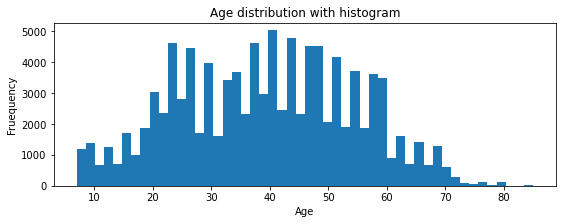

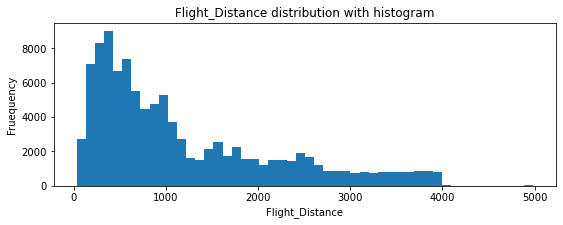

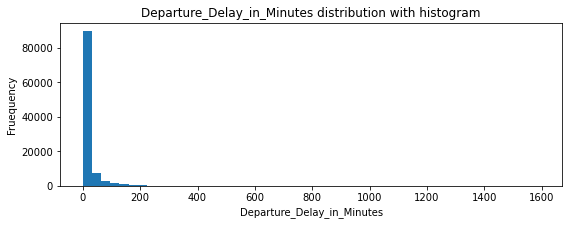

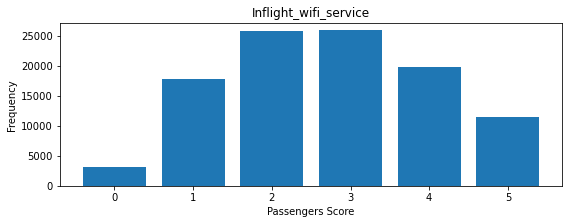

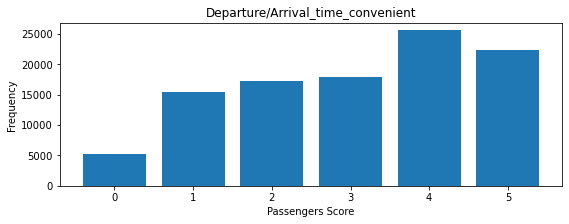

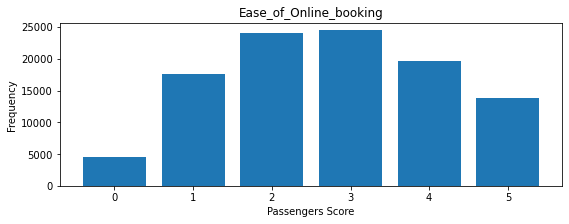

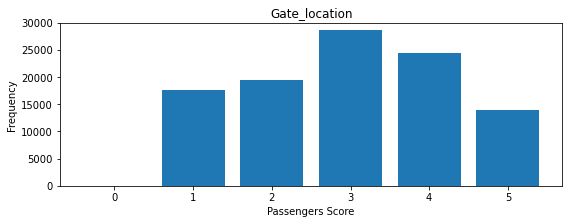

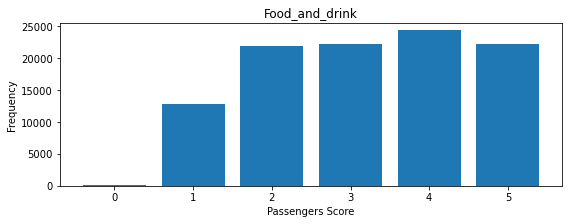

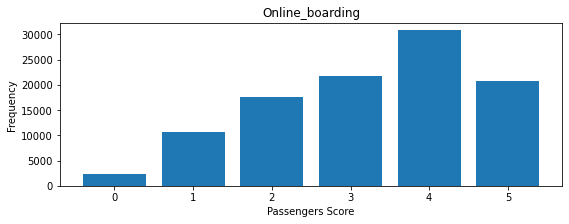

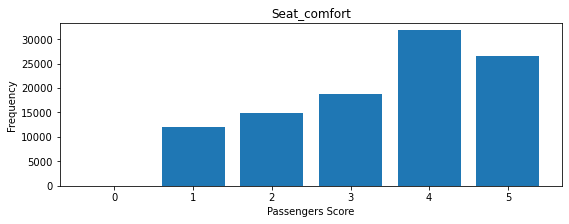

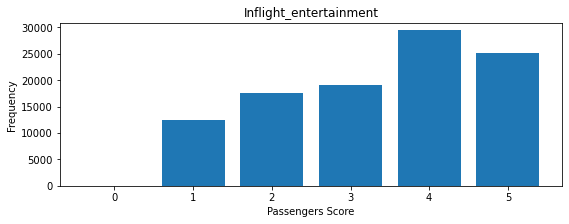

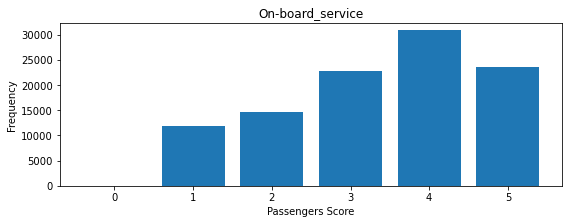

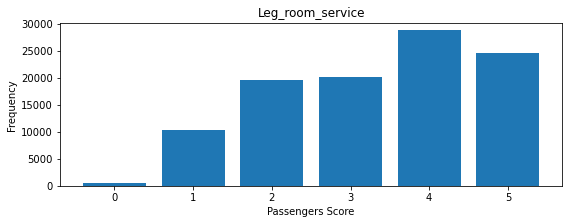

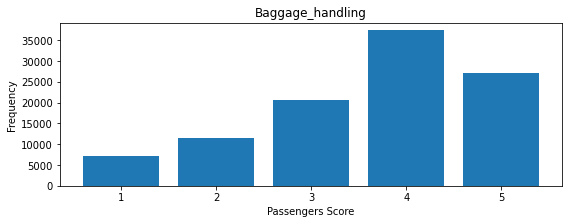

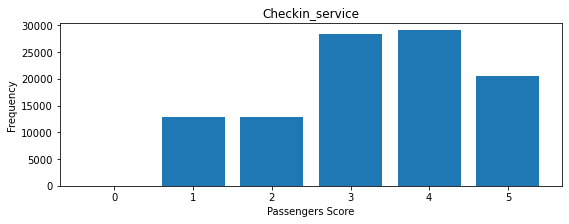

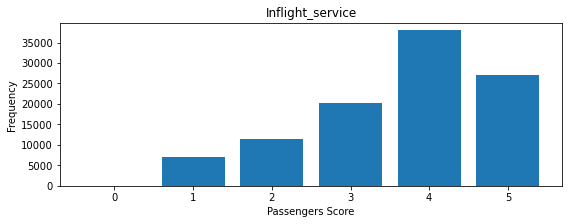

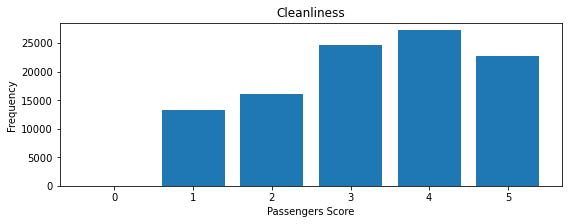

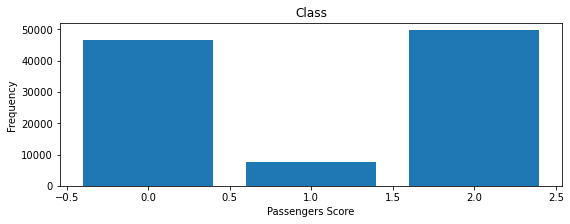

In [89]:
def plot_hist(variable):
    plt.figure(figsize=(9,3))
    plt.hist(df_train[variable],bins=50)
    plt.xlabel(variable)
    plt.ylabel("Fruequency")
    plt.title("{} distribution with histogram".format(variable))
    plt.show()
    
def bar_plot(variable):
    
    var=df_train[variable]
    var_Value=var.value_counts()
    
    #visualize
    plt.figure(figsize=(9,3))
    plt.bar(var_Value.index,var_Value.values)
    
    plt.xlabel("Passengers Score")
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
#     print("{}: \n {}".format(variable,var_Value))

    
for n in numericVar:
    plot_hist(n)
for c in category_ordinal:
    bar_plot(c)

**Analysis of each feature distibution:**
* ***Age*** - we notice the distributaion is fairly Gaussian.
* ***Flight Distance*** - we notice a Long tail distibution
* ***Departure Delay*** - Most of the values are close to 0 (delays are small) and therfore, not significant to satisfaction) 
* ***Inflight Wifi***  - Most frequent values are 2 & 3, indicating that the Wifi statisfaction is mostly average.
* ***Departure/Arrival time convenience*** - Most frequent values are 4 & 5, indicating that many passengers are staisfied with Departure/Arrival times.
* ***Ease of online booking*** - Most frequent values are 2 & 3, indicating that the Wifi statisfaction is mostly average.
* ***Gate Location*** - Most frequent value is 3, indicating an average satisfaction and thefore this might be the reason for having the lowest correlation with overall satisfaction.
* ***Food & Drink*** - Most frequent value is 4, but the values are distibuted quite evenly between 2-5 (0 has none, and 1 is less frequent)
* ***Online boarding,Baggage handaling*** - Most frequent value is 4, next frequent are 3,5, indicating fairly high staisfaction from these features, we note that Online boarding had the best correlation with the overall satisfaction while
  Baggage handling had significantly less corrleation (which  suprised us a bit). 
* ***Seat Comfort*** - Distribution is quite similar to Online boarding
* ***Inflight entertainment,On-board Service,Leg Room Service,Cleanliness,Inflight Service*** - Most frequent value is 4, next frequent value is 5, indicating quite high satisfaction
* ***Checking Service*** - most frequent values are 3,4.

**Checking to see if the classes are balanced in the dataset:**

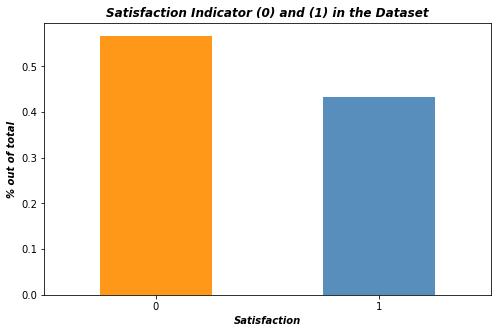

**We see that the people are divided quite equally (55%-45%) between the classes (dissatisfied/satisfied/),<br>**We conclude that the calsses are balanced enough and no further actions are required

In [345]:
fig = plt.figure(figsize = (8,5))
df_train.satisfaction.value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=0)
plt.title('Satisfaction Indicator (0) and (1) in the Dataset',fontweight='bold',style= 'italic')
plt.ylabel('% out of total',fontweight='bold',style= 'italic')
plt.xlabel('Satisfaction',fontweight='bold',style= 'italic')
plt.show()

md(
    f"**We see that the people are divided quite equally (55%-45%) between the classes (dissatisfied/satisfied/),<br>"
    f"**We conclude that the calsses are balanced enough and no further actions are required"
)

**t-SNE Visualization**<br>
First we try to visualize that how the satisfaction is related to all other dimensions (using all features)

In [54]:
X_train = df_train.drop(['satisfaction','Age_Group'],axis=1)

In [49]:
tsne = TSNE(perplexity = 4,n_iter=250,early_exaggeration=50,random_state=SEED)
tsne_results = tsne.fit_transform(X_train)

tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])

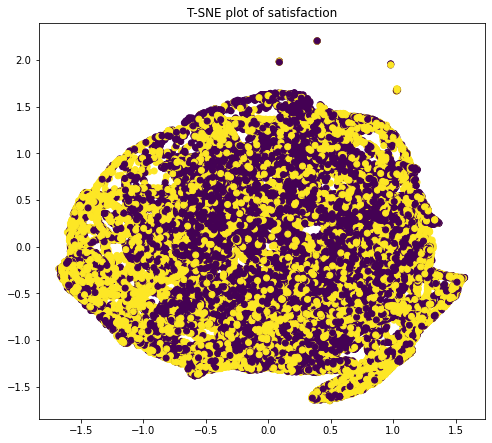

In [50]:
plt.figure(figsize = (8,4))
plt.subplots_adjust(top = 1.5)

plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=[df_train['satisfaction']])
plt.title("T-SNE plot of satisfaction")
plt.show()

**We didn't receive clear clusters of satisfied and unsatisfied individuals,<br>**
We will try to optimize the T-SNE by trying different values of hyperparameteres:<br>
* preplexity = [1,10,25,75]
* n_iter = 1000

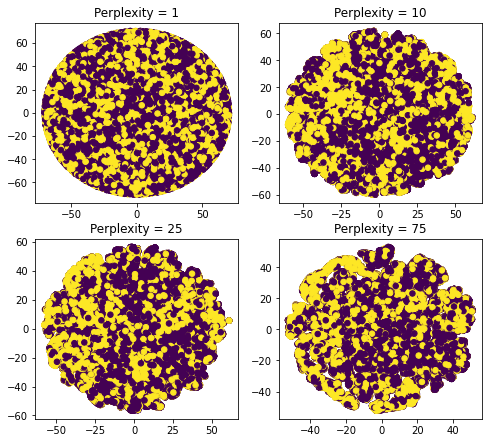

In [55]:
plt.figure(figsize = (8,4))
plt.subplots_adjust(top = 1.5)

for index, p in enumerate([1, 10, 25, 75]):

    tsne = TSNE(n_components = 2, perplexity = p, random_state=SEED)
    tsne_results = tsne.fit_transform(X_train)
    
    tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
    
    plt.subplot(2,2,index+1)
    plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=df_train['satisfaction'], s=30)
    plt.title('Perplexity = '+ str(p))
plt.show()

**Conclusion: We see that no clear clusters are formed for satisfaction, we will try to focus on the most correlated features: ('Class','Online_boarding','Type_of_Travel','Customer_Type')**

In [277]:
corr_features = ['Class','Online_boarding','Type_of_Travel','Customer_Type']
X_train = df_train[corr_features]

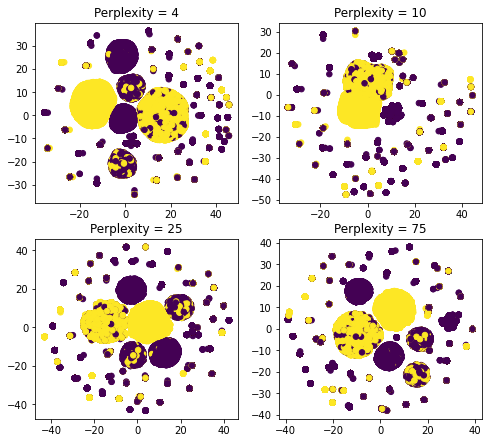

In [57]:
plt.figure(figsize = (8,4))
plt.subplots_adjust(top = 1.5)

for index, p in enumerate([4, 10, 25, 75]):

    tsne = TSNE(n_components = 2, perplexity = p, random_state=SEED)
    tsne_results = tsne.fit_transform(X_train)
    
    tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
    
    plt.subplot(2,2,index+1)
    plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=df_train['satisfaction'], s=30)
    plt.title('Perplexity = '+ str(p))
plt.show()

After selecting the features with the highest correlation, we see a better clusterin results, but still 
the clusters are not displayed very clearly 

**Trying t-SNE with perplexity = 250, n_iter = 2000, learning_rate=300 :** 

In [278]:
tsne = TSNE(perplexity = 250,n_iter=2000, learning_rate=300,random_state=SEED)
tsne_results = tsne.fit_transform(X_train)

tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])

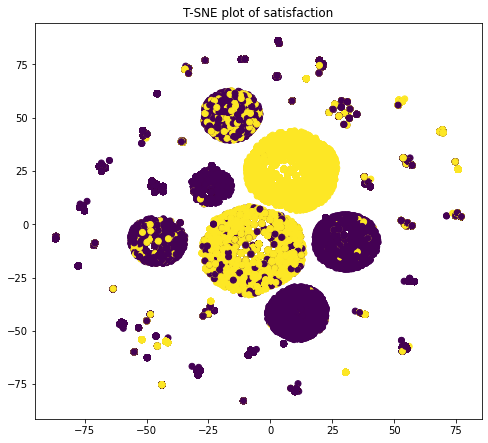

In [279]:
plt.figure(figsize = (8,4))
plt.subplots_adjust(top = 1.5)

plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=[df_train['satisfaction']])
plt.title("T-SNE plot of satisfaction")
plt.show()

## Task 4
### *A.Trying to determine which features influence the most on satisfaction*

Text(0.5, 1.0, 'Age vs Passenger Satisfaction')

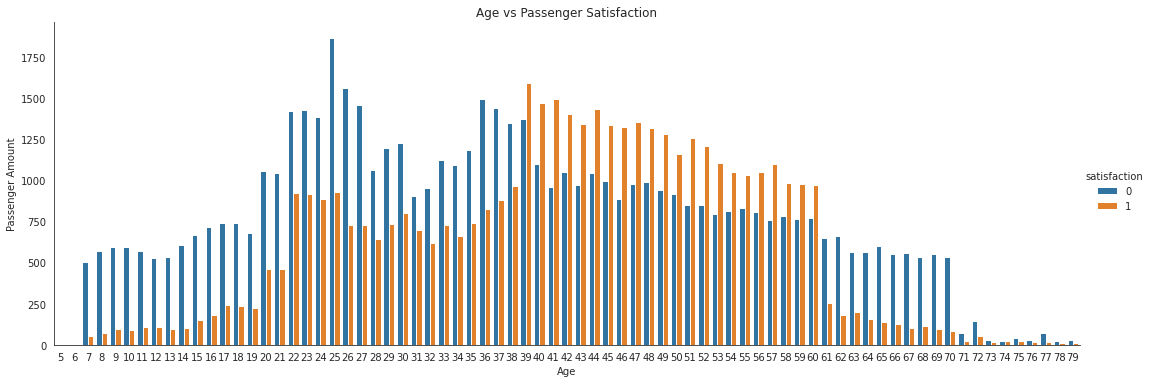

In [91]:
with sns.axes_style('white'):
    g = sns.catplot("Age", data=df_train, aspect=3.0, kind='count', hue='satisfaction', order=range(5, 80))
    g.set_ylabels('Passenger Amount')

plt.title('Age vs Passenger Satisfaction')

From age 7-to-38 and from age 61-to-79, number of dissatisfied passengers is very high compared to satisfied passengers.<br> On the contrary, in age range 39-60, number of satisfied passengers is higher compared to dissatisfied passengers.

From the diagram, we decide to perform a transformation for the age feature, into age intervals of [7-38,39-60,61-70,>=71], afterwards, we will check the correlation of the new feature to our label (satisfaction)

**Adding the engineered featured - Age_Group**

In [298]:
# first, creating the categories for each age group 
conditions = [
    (df_train['Age'] < 39),
    (df_train['Age'] > 38) & (df_train['Age'] < 61),
    (df_train['Age'] > 60) & (df_train['Age'] < 71),
    (df_train['Age'] > 70)
    ]

conditions2 = [
    (df_test['Age'] < 39),
    (df_test['Age'] > 38) & (df_test['Age'] < 61),
    (df_test['Age'] > 60) & (df_test['Age'] < 71),
    (df_test['Age'] > 70)
    ]
#  "young": 0, "adult": 1,"old": 2,"very old": 3
values = [0,1,2,3]


df_train['Age_Group'] = np.select(conditions, values)
df_test['Age_Group'] =  np.select(conditions2, values)

category_ordinal.append('Age_Group')


**Next, we will check the correlation of the new age group feature in a correlation matrix**

Text(0.5, 1.0, 'Feature Correlation Matrix')

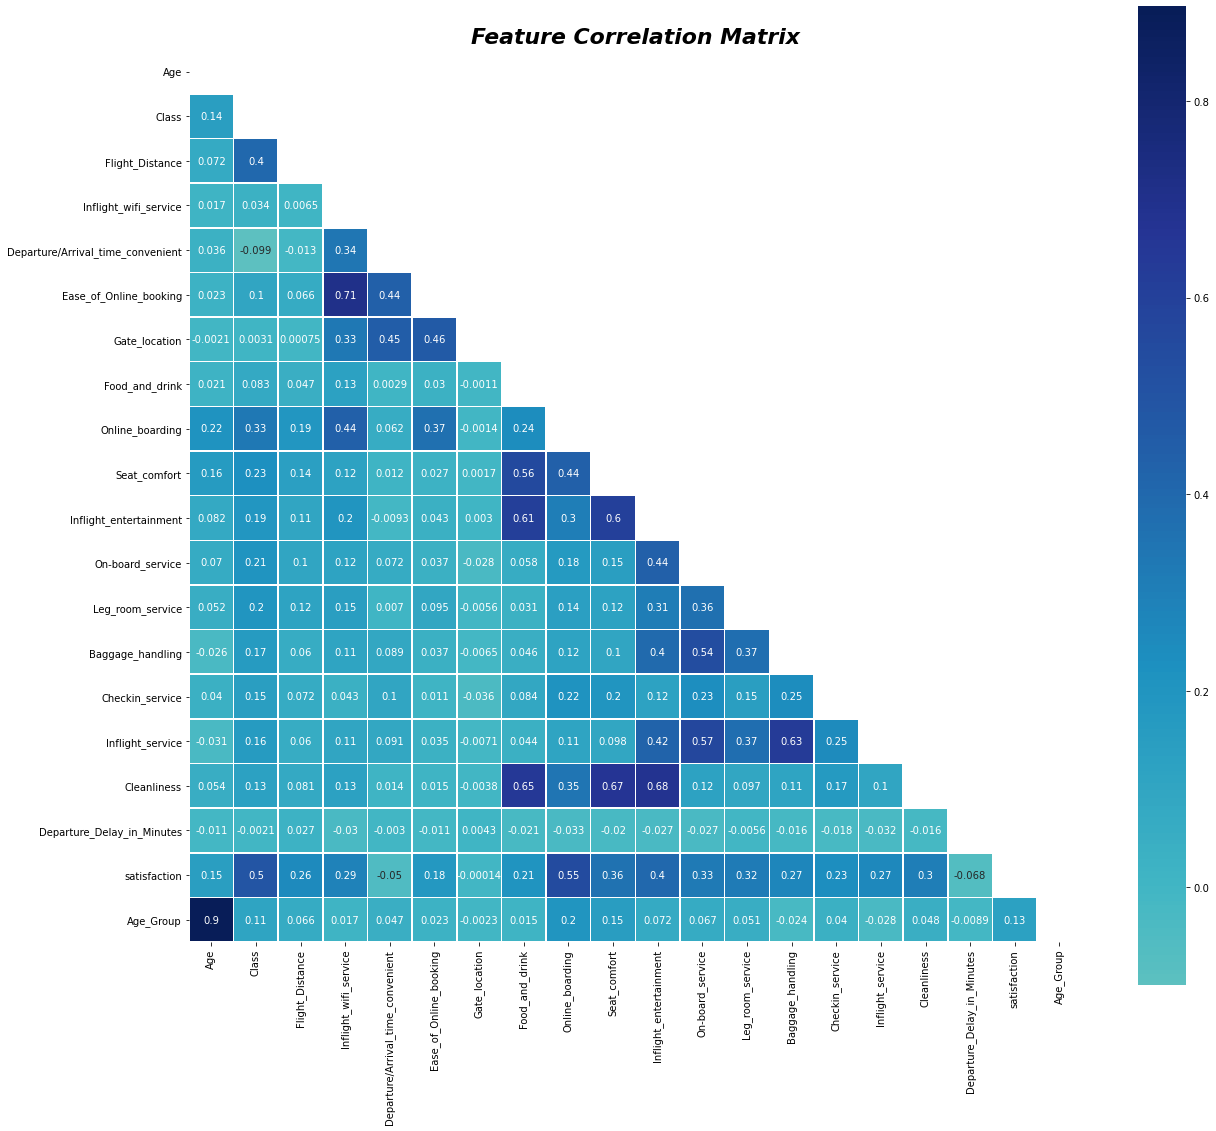

In [93]:
corr = df_train.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)
plt.title('Feature Correlation Matrix', fontweight='bold',style= 'italic',size=22)

**Unfortunately, we see that the new feature has a low correlation to satisfaction (even lower than the original feature), thefore, we conclude that this feature will not help the analysis.**

### PCA analysis

**We will try to see which features determine most of the explained varience usnig PCA on the numeric (& ordinal) features**

In [241]:
X_train = df_train[numericVar + category_ordinal]
# df_features = pd.concat([features_cat, x_numric], axis=1)

PCA requires feature Scaling as it measures variance along each dimension axis.<br> 
When dealing with numbers of different scale in rach feature, the variance cannot be compared, so we must scale the dataset. 

In [242]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# X_test = scaler.transform(df_test[numericVar])

In [243]:
pca = PCA(n_components=5,random_state=SEED)
pca.fit(X_train_scaled) # do the math
pca_data = pca.transform(X_train_scaled)

principalDf = pd.DataFrame(data = pca_data
             , columns = ['PC1','PC2','PC3','PC4','PC5'])
principalDf = pd.concat([principalDf, df_train[['satisfaction']]], axis = 1)

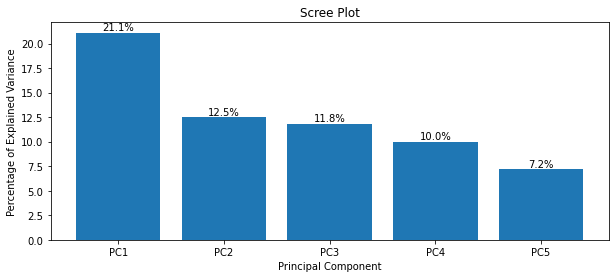

In [244]:
fig = plt.figure(figsize = (10,4))
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i+1, y[i]+0.25,'{:,.1%}'.format(y[i]/100), ha = 'center')
        
addlabels(labels,per_var)

plt.show()

**We can see from the Scree Plot that PC1,PC2,PC3 are responsible for about 45% of the Explained variance,<br>
We will use a 3D scatter plot to try and visualize the satisfaction clusters and their explained variance according to PC11,PC2,PC3**

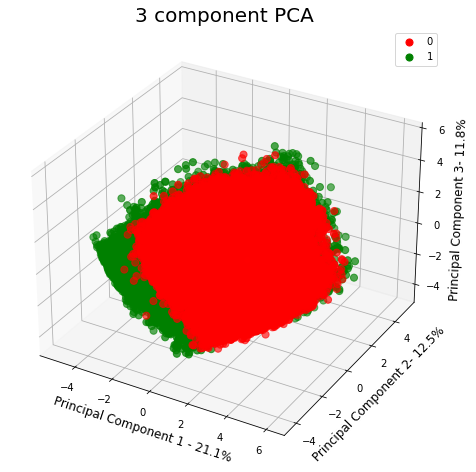

In [246]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('Principal Component 1 - {0}%'.format(per_var[0]), fontsize = 12)
ax.set_ylabel('Principal Component 2- {0}%'.format(per_var[1]), fontsize = 12)
ax.set_zlabel('Principal Component 3- {0}%'.format(per_var[2]), fontsize = 12)
ax.set_title('3 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['satisfaction'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'PC1']
               , principalDf.loc[indicesToKeep, 'PC2']
               , principalDf.loc[indicesToKeep, 'PC3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

**From the PCA visualization, we can see the 2 clusters (red - not satisfied, green - satisfied),<br>
we notice that the clusters are very dense and close to each other, indicating that the clusters differences are not very clear and obvious.<br>
This is not surprising as we saw that our features are not very well correlated to the satisfaction and PC1-PC3 reflect only 45% od the variance related to these features.**

**Next, we examine the loading which describe the weight of each feature in each of the Principal Components.**

In [149]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=X_train.columns)
loadings

PC1       PC2       PC3       PC4  \
Age                               -0.535820 -0.285242 -0.155851 -0.062241   
Flight_Distance                   -0.452538 -0.269541 -0.151568 -0.056694   
Departure_Delay_in_Minutes        -0.429990 -0.257429 -0.134708 -0.021217   
Inflight_wifi_service             -0.427261 -0.247164 -0.114417 -0.017036   
Departure/Arrival_time_convenient -0.419661 -0.244592 -0.108129  0.023529   
Ease_of_Online_booking            -0.418687 -0.219988 -0.101866  0.033016   
Gate_location                     -0.405426 -0.219738 -0.086543  0.040854   
Food_and_drink                    -0.339989 -0.215677 -0.086423  0.055152   
Online_boarding                   -0.338361 -0.163988 -0.085213  0.075057   
Seat_comfort                      -0.336180 -0.156514 -0.052115  0.075240   
Inflight_entertainment            -0.299930 -0.156003 -0.051873  0.090372   
On-board_service                  -0.298098 -0.136438 -0.045771  0.127137   
Leg_room_service                  -0.294148 -0.113942 -0.008808  0.131745   
Baggage_handling                  -0.269060 -0.102205  0.004325  0.151116   
Checkin_service                   -0.255752 -0.097340  0.017955  0.168567   
Inflight_service                  -0.210041 -0.084038  0.030027  0.195346   
Cleanliness                       -0.179655 -0.003817  0.035364  0.224908   
Class                             -0.146076  0.000664  0.049863  0.291692   
Age_Group                         -0.008055  0.028454  0.074240  0.296662   

                                        PC5  
Age                               -0.050085  
Flight_Distance                   -0.023993  
Departure_Delay_in_Minutes         0.020153  
Inflight_wifi_service              0.043833  
Departure/Arrival_time_convenient  0.074253  
Ease_of_Online_booking             0.084347  
Gate_location                      0.091193  
Food_and_drink                     0.112105  
Online_boarding                    0.133990  
Seat_comfort                       0.148646  
Inflight_entertainment             0.167183  
On-board_service                   0.257226  
Leg_room_service                   0.262201  
Baggage_handling                   0.278702  
Checkin_service                    0.293614  
Inflight_service                   0.540947  
Cleanliness                        0.555771  
Class                              0.561981  
Age_Group                          0.563161

**From the table above we can see that the features which have the greatest weight in PC1 are:** <br>
1. *Age*
2. *Flight_Distance* 
3. *Departure_Delay_in_minutes* 
4. *Inflight_wifi_service* 
5. *Departure/Arrival_time_convenient* 
6. *Ease_of_Online_booking* 
7. *Gate_location*

### *B. Applying KMeans clustering algorithm to try and determine the most relevant features:*
**We will use t-SNE to visualize the Kmeans clustering results.**

**We chose Kmeans due to several reasons:**
1. **The clusters are quite balance (same size) - in Kmeans the assumption is that each cluster has roughly same size.**
2. **Kmeans assumes all attributes variance of all features is rougly the same (spherical variance)** - from th PCA results - We conclude that PCA doesnt show any dominant feature which explaine the statisfaction variance much bettr than other, we noticed that 7 of the continuous numeric features contributes roghly the same weight to PC1 which is the major principal component of the PCA
3. **Kmeans algoritm require number of clusters as input and doesn't determine the number of clusters** - in our case we know that we need already 2 clusters (satisfied 0/1).

**We will try and use the best numerical and categorial features (with the highest correlation and variance contribution to satisfaction according to our investigation) as input to the Kmeans**

First we scale our features as KMeans uses Euclidean distances.                       

In [256]:
X_train = df_train.drop('satisfaction',axis=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
df_X_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)

In [265]:
kmeans = KMeans(2,random_state=SEED).fit(X_train_scaled)
df_X_scaled['Cluster'] = kmeans.labels_

In [266]:
tsne = TSNE(n_components = 2, perplexity =70, n_iter=500,random_state=SEED)
tsne_kmeans = tsne.fit_transform(df_X_scaled)

In [431]:
silhouette_score(df_X_scaled,kmeans.labels_)

0.1797364376769261

In [143]:
print("The received silhouette score for evaluating our clusters is 0.179")

The received silhouette score for evaluating our clusters is 0.179


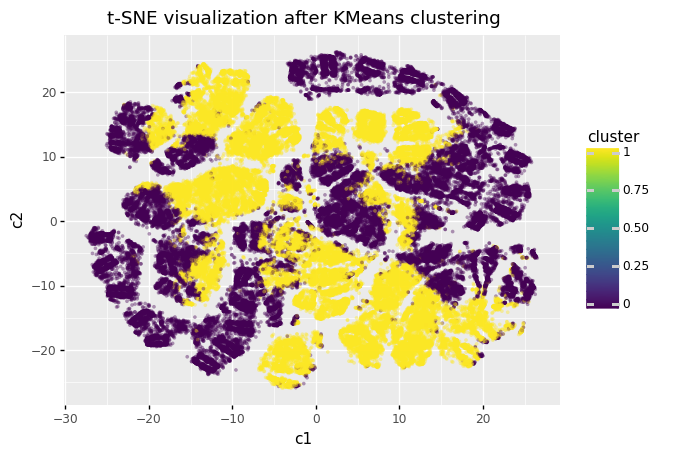

<ggplot: (161282819482)>

In [278]:
(
    ggplot(pd.DataFrame({"c1" : tsne_kmeans[: , 0]
                        ,"c2" : tsne_kmeans[: , 1]
                        ,"cluster" : kmeans.labels_}) , aes(x="c1" , y="c2" , fill="cluster"))
    + geom_point(alpha=0.4 , stroke=0) + ggtitle(title="t-SNE visualization after KMeans clustering")
)

**After trying hyper parameters of perplexity = 70, n_iter=500 , we see from the diagram that clusters are not that coherent and homogenous, this is further demonstated by the average silhouette score (0.179) we will try increasing both perplexity & n_iter and also early exageartion in order to try achieving better clusters.**

In [279]:
tsne = TSNE(n_components = 2, perplexity =100, n_iter=2000,early_exaggeration=100,random_state=SEED)
tsne_kmeans = tsne.fit_transform(df_X_scaled)

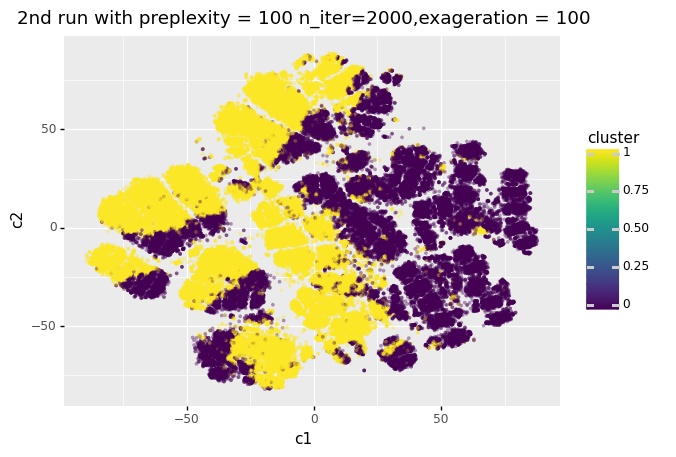

<ggplot: (161200622686)>

In [281]:
(
    ggplot(pd.DataFrame({"c1" : tsne_kmeans[: , 0]
                        ,"c2" : tsne_kmeans[: , 1]
                        ,"cluster" : kmeans.labels_}) , aes(x="c1" , y="c2" , fill="cluster"))
    + geom_point(alpha=0.4 , stroke=0) + ggtitle(title="2nd run with preplexity = 100 n_iter=2000,exageration = 100")
)

**Conclusion: using all the feature doesn't achieve good clusters, we will try to use only the best correlated clusters 
(best categorial + best numeric & ordinal found by PCA analysis)**

In [144]:
features = ['Age','Flight_Distance','Departure_Delay_in_Minutes','Inflight_wifi_service',
            'Departure/Arrival_time_convenient','Ease_of_Online_booking','Gate_location','Class','Type_of_Travel','Customer_Type']
X_train = df_train[features]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
df_X_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)

In [145]:
kmeans = KMeans(2,random_state=SEED).fit(X_train_scaled)
df_X_scaled['Cluster'] = kmeans.labels_

In [147]:
sil = silhouette_score(df_X_scaled,kmeans.labels_)

In [148]:
print("The received silhouette score for evaluating our clusters is ",sil)

The received silhouette score for evaluating our clusters is  0.17975597824088885


In [286]:
tsne = TSNE(n_components = 2, perplexity = 70, n_iter=2000,random_state=SEED)
tsne_kmeans = tsne.fit_transform(df_X_scaled)

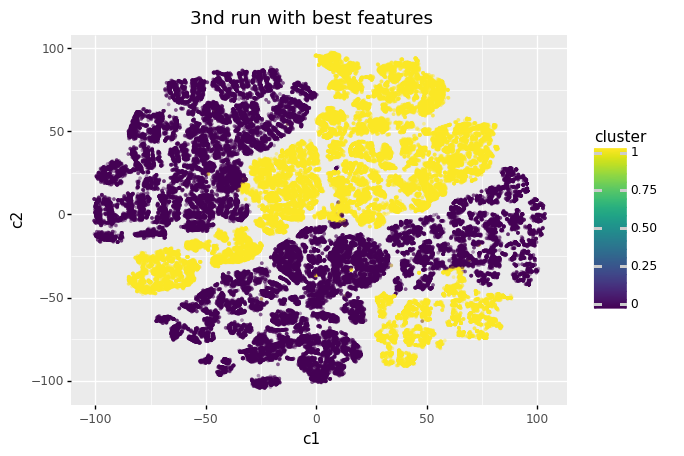

<ggplot: (161282207308)>

In [287]:
(
    ggplot(pd.DataFrame({"c1" : tsne_kmeans[: , 0]
                        ,"c2" : tsne_kmeans[: , 1]
                        ,"cluster" : kmeans.labels_}) , aes(x="c1" , y="c2" , fill="cluster"))
    + geom_point(alpha=0.4 , stroke=0) + ggtitle(title="3nd run with best features")
)

**Conclusion: also after trying best correlated features, we don't see very good clusters, we assume that KMeans might not be the best clustering algorithm so we will try another clustring technique.**

**We didn't see much of a diffrence in silhouette scores when using all of the features or just the features we estimated to be the best (based on their correlation)**

### *C. Applying Agglomerative clustering algorithm to try and determine the most relevant features:*
**We will use a sample of size 10000 in order to receive quicker runtime**

In [149]:
features = ["Online_boarding", "Seat_comfort", "Inflight_entertainment", "On-board_service",
                     "Leg_room_service", "Cleanliness","Class"]
data = df_train.sample(10000).iloc[:, :]
X_train = data[features].values

**First, we will create a dendogram for verifying the required number of clusters**

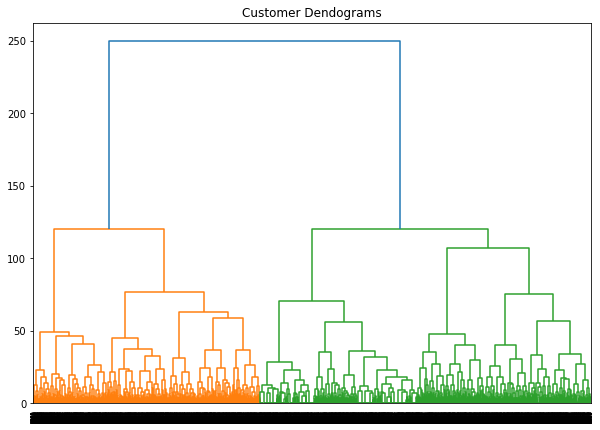

In [295]:
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X_train, method='ward'))

**From the dendogram we conclude that the the optimal number of clusters is 2**

**Next , we will perform the hierarchical clustering**

In [150]:
cluster = AggClus(n_clusters=2, affinity='euclidean', linkage='ward')
clusters = cluster.fit_predict(X_train)

In [297]:
df_agg = data.copy()
df_agg['Cluster'] = clusters
df_agg['satisfaction']= data['satisfaction']
df_agg

Gender Customer_Type  Age Type_of_Travel  Class  Flight_Distance  \
4212       0             0   29              1      2             1907   
10334      0             0   40              1      2             3018   
6859       0             0   67              0      0              237   
25480      1             1   36              1      2              423   
97193      1             1   21              1      0              689   
...      ...           ...  ...            ...    ...              ...   
63824      0             0   64              0      2              297   
20373      0             1   37              1      0             1010   
96848      0             0   37              1      0              376   
94023      1             0   44              0      0              447   
28884      1             0   40              1      2              374   

       Inflight_wifi_service  Departure/Arrival_time_convenient  \
4212                       4                                  4   
10334                      2                                  5   
6859                       2                                  4   
25480                      3                                  3   
97193                      4                                  4   
...                      ...                                ...   
63824                      2                                  4   
20373                      3                                  3   
96848                      5                                  4   
94023                      0                                  4   
28884                      2                                  2   

       Ease_of_Online_booking  Gate_location  ...  On-board_service  \
4212                        4              4  ...                 4   
10334                       5              5  ...                 2   
6859                        0              5  ...                 5   
25480                       3              3  ...                 4   
97193                       4              4  ...                 3   
...                       ...            ...  ...               ...   
63824                       2              3  ...                 1   
20373                       3              3  ...                 3   
96848                       2              4  ...                 3   
94023                       0              4  ...                 5   
28884                       2              2  ...                 5   

       Leg_room_service  Baggage_handling  Checkin_service  Inflight_service  \
4212                  5                 5                3                 4   
10334                 2                 2                2                 2   
6859                  3                 5                3                 5   
25480                 4                 5                5                 4   
97193                 2                 3                3                 4   
...                 ...               ...              ...               ...   
63824                 2                 1                3                 1   
20373                 5                 4                3                 3   
96848                 1                 4                5                 1   
94023                 0                 2                3                 5   
28884                 5                 5                3                 5   

       Cleanliness  Departure_Delay_in_Minutes  satisfaction  Age_Group  \
4212             4                          35             1          0   
10334            2                          29             0          1   
6859             2                           1             0          2   
25480            1                           0             0          0   
97193            2                           0             0          0   
...            ...                         ...  

In [151]:
sil = silhouette_score(X_train,clusters)

In [152]:
print("The received silhouette score for evaluating our clusters is ",sil)

The received silhouette score for evaluating our clusters is  0.2528457748932009


**Next we will examine the clusters purity**<br> (we aim to have clusters which are uniform , all the points belonging to 'not satisfied' group in the first cluster and belong to 'satisfied' group on the second cluster)

In [304]:
not_satisfied_cluster = df_agg[(df_agg['Cluster']==1)]
not_satisfied_cluster['satisfaction'].value_counts()

0    3365
1     699
Name: satisfaction, dtype: int64

In [324]:
purity_ratio = len(not_satisfied_cluster[not_satisfied_cluster['satisfaction']==0])/len(not_satisfied_cluster)
print ('The purity ratio on the first cluster is:',purity_ratio)

The purity ratio on the first cluster is: 0.828001968503937


In [305]:
satisfied_cluster = df_agg[(df_agg['Cluster']==0)]
satisfied_cluster['satisfaction'].value_counts()

1    3623
0    2313
Name: satisfaction, dtype: int64

In [325]:
purity_ratio = len(satisfied_cluster[satisfied_cluster['satisfaction']==1])/len(satisfied_cluster)
print ('The purity ratio on the second cluster is:',purity_ratio)

The purity ratio on the second cluster is: 0.6103436657681941


**Conclusion - the 2 clusters receive after hierarchical clustering are quite pure:**<br>
- The first cluster has very high purity rate of **83%**.
- The second cluster has average purtiy rate of **61%**.

we also note that the silhouette score is better than Kmeans (0.179->0.252)

**Next we will use t-SNE to visualize the 2 clusters:**

In [328]:
tsne = TSNE(n_components = 2, perplexity = 100, n_iter=2000,random_state=SEED)
tsne_agg = tsne.fit_transform(df_agg.drop('satisfaction',axis=1))

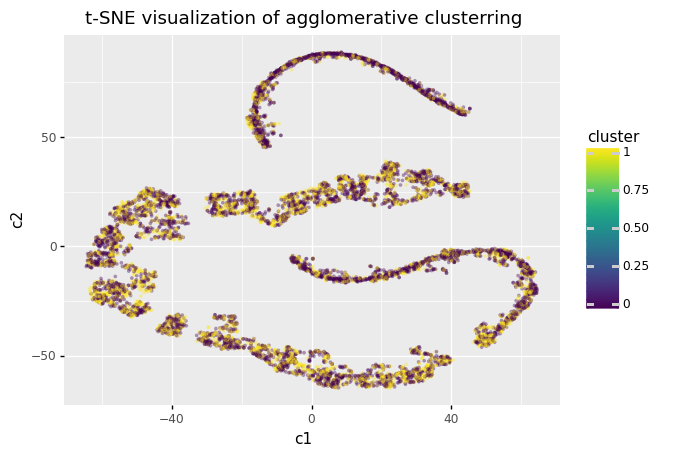

<ggplot: (161214590552)>

In [330]:
(
    ggplot(pd.DataFrame({"c1" : tsne_agg[: , 0]
                        ,"c2" : tsne_agg[: , 1]
                        ,"cluster" : clusters}) , aes(x="c1" , y="c2" , fill="cluster"))
    + geom_point(alpha=0.4 , stroke=0) + ggtitle(title="t-SNE visualization of agglomerative clusterring")
)

### *D. SOM visualisation* 
**We use te same sample of 10000 rows (due to long runtimes) from the dataset to try and visualize clusters via SOM model, for the purpose,
we use the same 7 features used for agglomerative clustering**

In [427]:
net = sps.somNet(40, 40, X_train, PBC=True, PCI=True)

Periodic Boundary Conditions active.
The weights will be initialised with PCA.


In [428]:
#Now we can train it with 0.1 learning rate for 10000 epochs
net.train(0.1, 10000)

Training SOM... done!


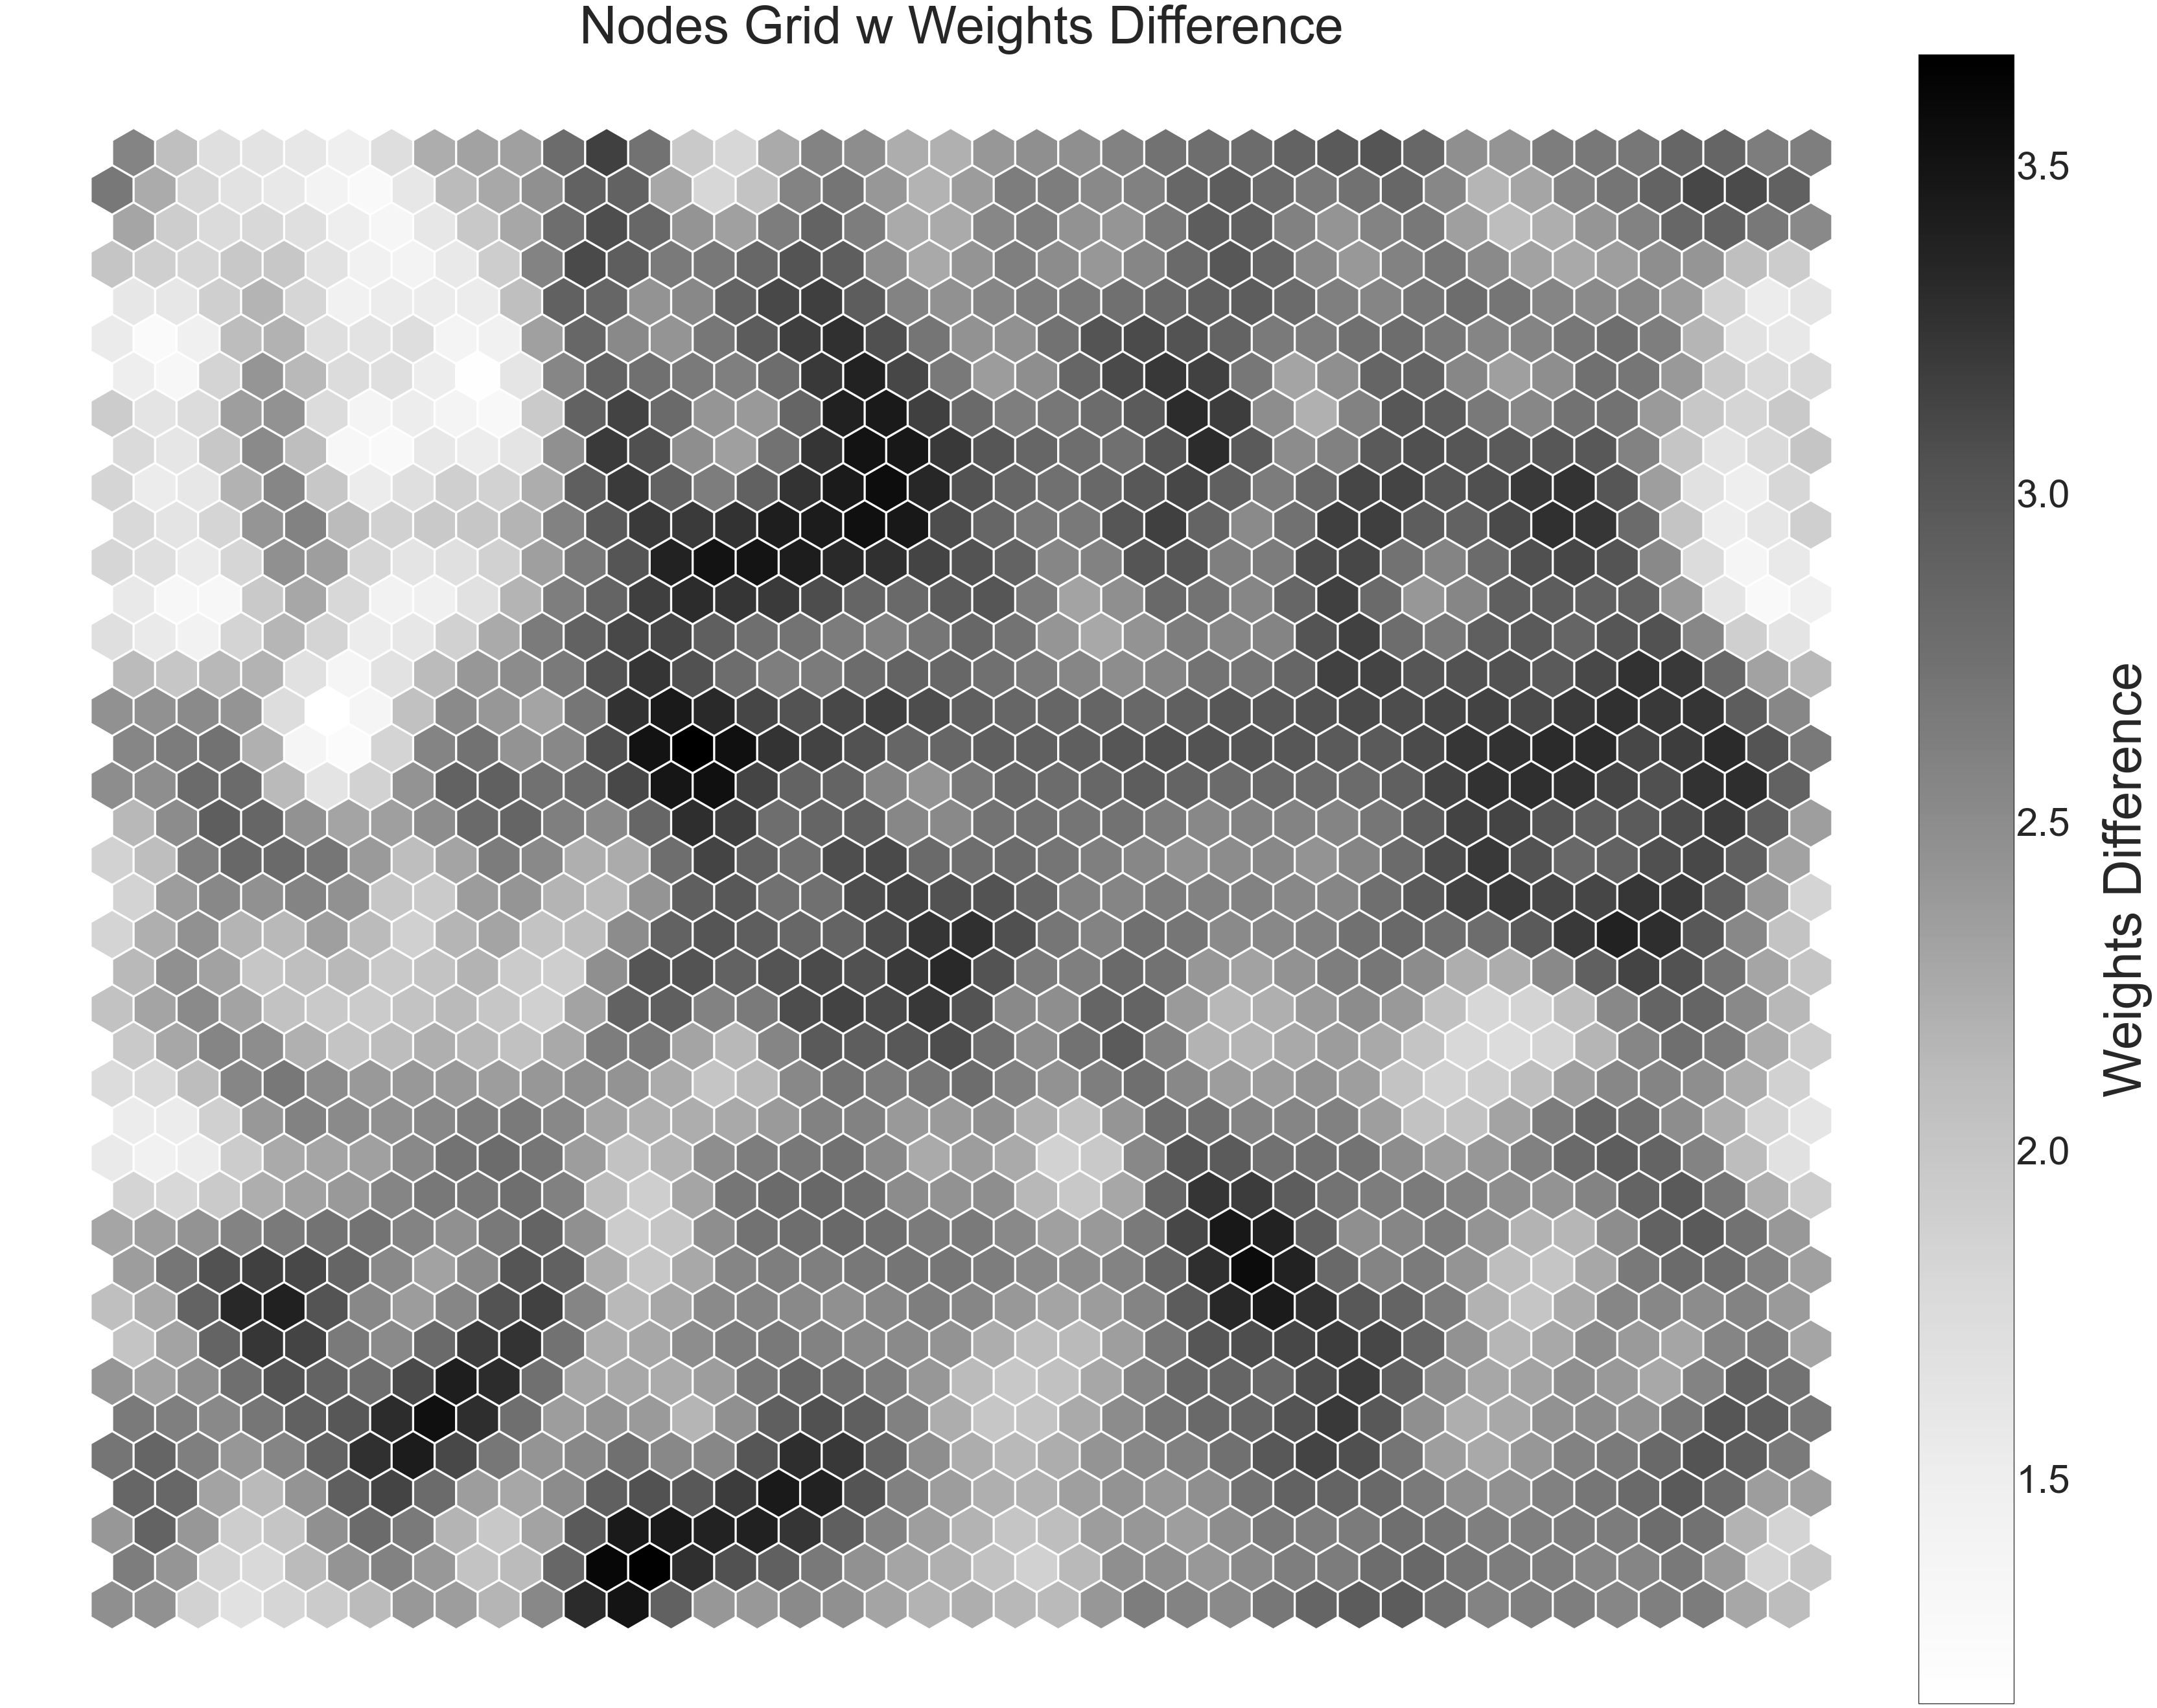

<Figure size 432x288 with 0 Axes>

In [429]:
net.diff_graph(show=True,printout=True)

**Analysis of the heatmap above:**<br>
* The dark nodes incdicate areas where neighbouring nodes are relatively close to each other and therefore might suggest a cluster.
* The white nodes indicate areas where neighboring nodes are relatively far from each other and therefore reflect areas of sepreation between the clusters (which are black)

* As can be seen, there are no clear seperate 2 clusters which might clearly reflect the satisfaction (0/1) although we do seen areas which are more dark (top right zone, bottom left zone) and more white (top left zone,bottom right zone) 

* Possible reasons for the ambiguous results:
     - The SOM analysis was perform on a 10000 size sample of the dataset which not necessarily represents the entire dataset reliably. 
     - It is possible that the model could have been further optimze by selecting different hyper parameters (we chose several combination but displayed only the best execution)

## Summary of task 4:
**We used several techniques to try and find the best feature which influence the satisfaction:**

1. Already from the data explaoration phase, we used the correlation matrix to analyzewe noticed the features with the best correlation ("Online_boarding", "Seat_comfort", "Inflight_entertainment", "On-board_service","Leg_room_service", "Cleanliness","Class").


2. We first try to visualize the satisfaction clusters based on all the features by using visualization and dimensions reduction techniques which such as *PCA* (we examine which feature contribute the most the PC1 and also 3D scatterplot of the clusters using PC1-PC3 as the X,Y,Z axes) and also *t-SNE* and *SOM*. we tried to optimize *t-SNE* few times by slecting different preplexity and n_iter value and also exaguration.<br>
<br>
3. We also tried to utilzed clustering models such as *Kmeans* (as we saw the clusters should be roughly the same size and variance seem to be roughly the same on all dimensions (spherical) - we saw rhat from the exploratory analysis on Task 3 when we observed each feature seperately - we again tried to visualize the Kmean results with t-SNE answ again the clusters were not very clear.


4. After *Kmeans*, we used *Agglomerative clustering* as this clustering method can be used on almost all kind of datsets without the need of prior assumptions, the dendogram supported the division to 2 clusters, but again after t_SNE visualzation of  the clusters, we cluldnt see clear clusters.


5. **We conclude that due to the relative average correlations of the features (best correlation was only 0.55 via Spearman coeffient, which is fairly average), the influence on the satisfaction could not be detected clearly although we tried to find it using different analysis techniques.**

# Task 5

**We will try to optimize the classification by 4 different models (Adaboost,Random Forest,MLP & XGBoost) with same testing features in order to find the most appropriate model which achieves the hightest accuracy.**<br><br>

we measure accuracy by these 3 indicators:
* $Accuracy$ = $\frac{TP+TN}{TP+TN+FP+FN}$ (***The fraction of predictions our model got right***) 
* $Recall$ = $\frac{TP}{TP+FN}$  (***The proportion of actual positives was identified correctly?***)
* $Precision$ = $\frac{TP}{TP+FP}$ (***The proportion of positive identifications was actually correct?***)
* $F1$ = $2*\frac{Precision*Recall}{Precision+Recall}$ (***F1 is the harmonic mean of precision and recall***)

As we consider both recall and precision equally important indicator for calssification, we want to maximize both and hence, will look at F1 score which is the harmonic mean of both

***The process:***<br>
We tried different combinations from these list of features:<br>
"Online_boarding", "Seat_comfort", "Inflight_entertainment", "On-board_service","Leg_room_service", "Cleanliness","Class".<br>
Those features are the most correlated features with our label according to the correlation matrix from the pre-proccessing step. <br>
We used 4 different classifier models with choosing some of the features in each iteration in order to find the features which yields best results - the highest accuracy of predictions.<br>

After several executions, we tried to expand the number of features we used and found out that more features raised the accuracy,<br> therefore, we decided to remove only 2 features - 'Gate_Location' (worst correlated to our label) and 'Age_Group' which were already identified earlier as not helpful according the correlation matrix, and used all the other features.

For each model, we first run it without hyper parameter optimization (gridsearchCV) and then add the gridsearch to demonstarte the performance improvement.

In [1]:
# Help function to be use later in the task
def create_matrix(clf_matrix, model):
    group_counts = ["{0:0.0f}".format(value) for value in
                clf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     clf_matrix.flatten()/np.sum(clf_matrix)]
    labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(clf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix- "+ model, fontsize = 20)

## 1.AdaBoost Classifier 

First try - best sellected features without optimization:

In [101]:
# first, Choosing features according the corelation matrix for the learning of the models.
features_classifier =["Online_boarding", "Seat_comfort", "Inflight_entertainment", "On-board_service",
                     "Leg_room_service", "Cleanliness","Class"]

# Normalized the features
X_train = df_train[features_classifier]
X_test = df_test[features_classifier]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
df_X_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
df_X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)

train_x = df_X_scaled
train_y = df_train['satisfaction']

to_predict = df_X_test
test_lables = df_test['satisfaction']


In [58]:
# Build and train the model without optimization
adab_first = AdaBoostClassifier(random_state=SEED)
adab_first.fit(train_x, train_y)

# Predict the response for test dataset
adab_first_pred = adab_first.predict(to_predict)
acc=metrics.accuracy_score(test_lables, adab_first_pred)

In [59]:
print("The accuracy of AdaBoost model without optimization: ",acc)
print("Meaning,",round(acc*100,2),"% of the samples were classified correctly")

The accuracy of AdaBoost model without optimization:  0.8487834924545734
Meaning, 84.88 % of the samples were classified correctly


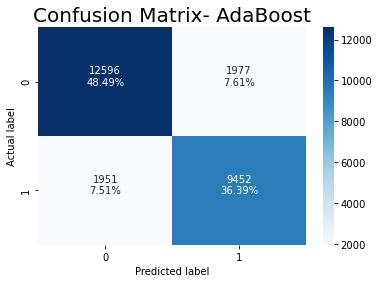

In [60]:
# Visualization of the results
adab_matrix = metrics.confusion_matrix(test_lables,adab_first_pred)
create_matrix(adab_matrix, 'AdaBoost')

In [61]:
precision = precision_score(test_lables,adab_first_pred)
recall = recall_score(test_lables,adab_first_pred)
f1 = f1_score(test_lables,adab_first_pred)
print("Precision = ",precision)
print('Recall = ',recall)
print('F1 score =',f1)

Precision =  0.8270189867879955
Recall =  0.8289046742085416
F1 score = 0.8279607568325158


**Although We received pretty good results but we want to rty and imporve them by optimzing the model.<br>**
**Next, we use GridsearchCV to optimize the hyper parameters and expect improved results**

Second Try - best selected features with GridsearchCV

In [99]:
# Build the AdaBoost model 
adab = AdaBoostClassifier()

# Optimization to the model
adab_param_grid = {'n_estimators':[50,100,150,200],  
                  'learning_rate':[0.001, 0.01, 0.1, 1], 
                  'random_state': [SEED]}

gs_adab = GridSearchCV(adab, param_grid = adab_param_grid, cv=5, scoring="accuracy", n_jobs= -1)
gs_adab.fit(train_x, train_y)

adab_second_best = gs_adab.best_estimator_
print("Best Parameters:\n", gs_adab.best_params_)

Best Parameters:
 {'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 1}


In [102]:
# Create new model according to the best parameters we got
adab_second = AdaBoostClassifier(adab_second_best)

# Train the model
adab_second.fit(train_x, train_y)

# Predict the response for test dataset
y_pred=adab_second_best.predict(to_predict)
print("The accuracy: ",metrics.accuracy_score(test_lables,y_pred))

The accuracy:  0.8505158607945796


In [103]:
print("Meaning,",round(metrics.accuracy_score(test_lables,y_pred)*100,2),"% of the samples were classified correctly")

Meaning, 85.05 % of the samples were classified correctly


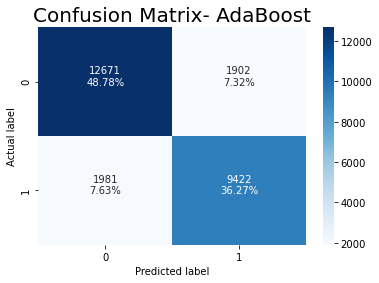

In [104]:
# Visualization of the results
adab_matrix = metrics.confusion_matrix(test_lables,y_pred)
create_matrix(adab_matrix, 'AdaBoost')

In [105]:
precision = precision_score(test_lables,y_pred)
recall = recall_score(test_lables,y_pred)
f1 = f1_score(test_lables,y_pred)
print("Precision = ",precision)
print('Recall = ',recall)
print('F1 score =',f1)

Precision =  0.832038149063935
Recall =  0.8262737875997545
F1 score = 0.829145949751397


Text(0.5, 1.0, 'Feature Importance')

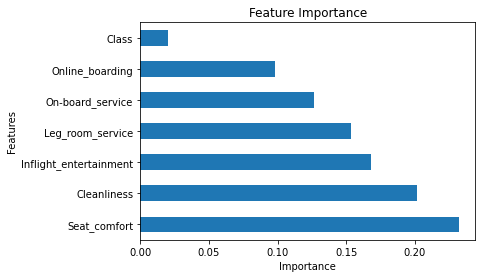

In [106]:
#Display the importance of each feature
feat_importances = pd.Series(adab_second.feature_importances_, index=to_predict.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')

**From the feature importance analysis, we see that almost all 7 features contributed to the classifaction except Class**

**Conclusion: After gridsearch optimization, we see a very small improvement on the F1 score (0.827->0.829).<br>
Next, we try using all the features and not just the "best correlated features"**

Third Try - All the feature except 'Age_Group' & 'Gate_location' without gridsearch optimzation

In [109]:
# All features except 'Age_Group' & 'Gate_location'
features =["Inflight_wifi_service", "Departure/Arrival_time_convenient", "Ease_of_Online_booking",
           "Food_and_drink", "Online_boarding", "Seat_comfort", "Inflight_entertainment", "On-board_service",
           "Leg_room_service", "Baggage_handling", "Checkin_service", "Inflight_service", "Cleanliness","Class","Gender",
           "Customer_Type", "Type_of_Travel","Flight_Distance", "Departure_Delay_in_Minutes", 'Age']

# Normalized the features
X_train = df_train[features]
X_test = df_test[features]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
df_X_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
df_X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)

train_x = df_X_scaled
train_y = df_train['satisfaction']

to_predict = df_X_test
test_lables = df_test['satisfaction']

In [76]:
# Build and train the model without optimization
adab_third = AdaBoostClassifier(random_state=SEED)
adab_third.fit(train_x, train_y)

# Predict the response for test dataset
adab_third_pred = adab_third.predict(to_predict)
acc=metrics.accuracy_score(test_lables, adab_third_pred)

In [79]:
print("The accuracy of AdaBoost with almost all features model without optimization: ",acc)
print("Meaning,",round(acc*100,2),"% of the samples were classified correctly")

The accuracy of AdaBoost with almost all features model without optimization:  0.9249307052663998
Meaning, 92.49 % of the samples were classified correctly


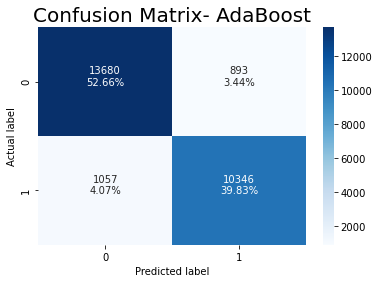

In [80]:
# Visualization of the results
adab_matrix = metrics.confusion_matrix(test_lables,adab_third_pred)
create_matrix(adab_matrix, 'AdaBoost')

In [81]:
precision = precision_score(test_lables,adab_third_pred)
recall = recall_score(test_lables,adab_third_pred)
f1 = f1_score(test_lables,adab_third_pred)
print("Precision = ",precision)
print('Recall = ',recall)
print('F1 score =',f1)

Precision =  0.920544532431711
Recall =  0.907305095150399
F1 score = 0.9138768660012367


**We see that when all the features are given to the classifier, a significant improvement in performance is received (F1 score: 0.829->0.913),<br>
Next we will optimize even further with gridsearch**

Fourth Try - All the feature except 'Age_Group' & 'Gate_location' with gridsearch optimzation

In [82]:
# Build the AdaBoost model 
adab = AdaBoostClassifier()

# Optimization to the model
adab_param_grid = {'n_estimators':[50,100,150,200],  
                  'learning_rate':[0.001, 0.01, 0.1, 1], 
                  'random_state': [SEED]}

gs_adab = GridSearchCV(adab, param_grid = adab_param_grid, cv=5, scoring="accuracy", n_jobs= -1)

# Train the model
gs_adab.fit(train_x, train_y)

# Predict the response for test dataset
adab_fourth = gs_adab.predict(to_predict)

In [89]:
ADB_best_fourth = gs_adab.best_estimator_
print("Best Parameters:\n", gs_adab.best_params_)

Best Parameters:
 {'learning_rate': 1, 'n_estimators': 150, 'random_state': 1}


In [91]:
# Create new model according to the best parameters we got
adab_best_fourth = AdaBoostClassifier(ADB_best_fourth)

# Train the model
adab_best_fourth.fit(train_x, train_y)

# Predict the response for test dataset
y_pred=adab_best_fourth.predict(to_predict)
print("The accuracy: ",metrics.accuracy_score(test_lables,y_pred))

The accuracy:  0.9286649214659686


In [96]:
print("Meaning,",round(metrics.accuracy_score(test_lables,y_pred)*100,2),"% of the samples were classified correctly")

Meaning, 92.87 % of the samples were classified correctly


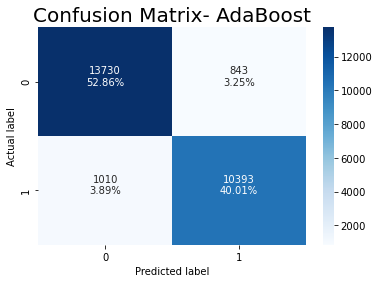

In [94]:
# Visualization of the results
adab_matrix = metrics.confusion_matrix(test_lables,y_pred)
create_matrix(adab_matrix, 'AdaBoost')

In [95]:
precision = precision_score(test_lables,y_pred)
recall = recall_score(test_lables,y_pred)
f1 = f1_score(test_lables,y_pred)
print("Precision = ",precision)
print('Recall = ',recall)
print('F1 score =',f1)

Precision =  0.9249733001067996
Recall =  0.9114268175041655
F1 score = 0.9181500949688589


**Again, after gridsearch optimization, we see a very small improvement on the F1 score (0.913->0.918).**

Text(0.5, 1.0, 'Feature Importance')

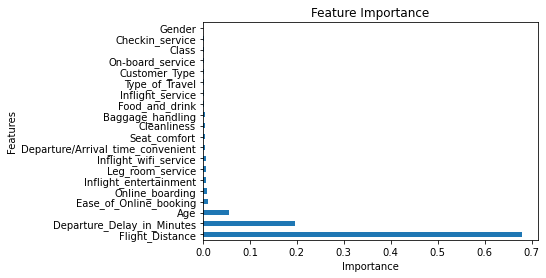

In [92]:
#Display the importance of each feature
feat_importances = pd.Series(adab_best_fourth.feature_importances_, index=to_predict.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')

**From the Feature importance analysis, we see that in fact, the classfier mainly used 3 features : "Flight_distance", Departure_Delay_in_Minutes" and "Age"**

**In conclusion, we see that the Adaboost works best with almost all features but mainly uses only 3 of them, additionaly GridsearchCV optimization has only little effect.**

## 2.RandomForest Classifier

As we saw in the Adaboost classfier that all features together (except 2) yielded best performance, we stick with these features

First Try - without GridSearch optimization

In [110]:
# All features except 'Age_Group' & 'Gate_location'
features =["Inflight_wifi_service", "Departure/Arrival_time_convenient", "Ease_of_Online_booking",
           "Food_and_drink", "Online_boarding", "Seat_comfort", "Inflight_entertainment", "On-board_service",
           "Leg_room_service", "Baggage_handling", "Checkin_service", "Inflight_service", "Cleanliness","Class","Gender",
           "Customer_Type", "Type_of_Travel","Flight_Distance", "Departure_Delay_in_Minutes", 'Age']

# Normalized the features
X_train = df_train[features]
X_test = df_test[features]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
df_X_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
df_X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)

train_x = df_X_scaled
train_y = df_train['satisfaction']

to_predict = df_X_test
test_lables = df_test['satisfaction']

In [111]:
# Build and train the model without optimization
rand_first = RandomForestClassifier(random_state=SEED)
rand_first.fit(train_x, train_y)

# Predict the response for test dataset
rand_first_pred = rand_first.predict(to_predict)

In [112]:
acc=metrics.accuracy_score(test_lables, rand_first_pred)

In [113]:
print("The accuracy of Random Forest with almost all features model without gridSearch optimization: ",acc)
print("Meaning,",round(acc*100,2),"% of the samples were classified correctly")

The accuracy of Random Forest with almost all features model without gridSearch optimization:  0.9632737911918694
Meaning, 96.33 % of the samples were classified correctly


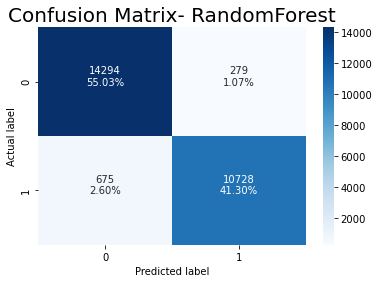

In [114]:
# Visualization of the results
rf_matrix = metrics.confusion_matrix(test_lables,rand_first_pred)
create_matrix(rf_matrix, 'RandomForest')

In [115]:
precision = precision_score(test_lables,rand_first_pred)
recall = recall_score(test_lables,rand_first_pred)
f1 = f1_score(test_lables,rand_first_pred)
print("Precision = ",precision)
print('Recall = ',recall)
print('F1 score =',f1)

Precision =  0.9746524938675388
Recall =  0.9408050513022889
F1 score = 0.957429718875502


Text(0.5, 1.0, 'Feature Importance')

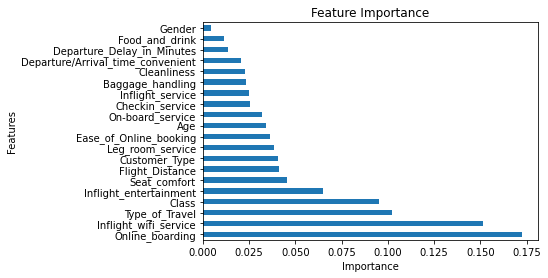

In [116]:
#Display the importance of each feature
feat_importances = pd.Series(rand_first.feature_importances_, index=to_predict.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')

**We see that the Random Forest performs better than the Adaboost classfier (F1 score improved 0.918->0.957), even without gridsearch optimization.<br>
We also notice that the major improvement in performance was related precision (0.924->0.974) compared to the recall which also improved but a bit less (0.911->0.940) <br>
In addition, we noticed that unlike the Adaboost which used mainly 3 of the features, Random Forest uses much more features.**<br>

**Next , we add gridsearch optimization for additional performance improvement**

Second Try - with GridSearch optimization

In [117]:
# Build the RandomForest model 
rand_forest = RandomForestClassifier()

# Optimization to the model
rf_param_grid = {'n_estimators':[50,100,150,200],  
                  'criterion': ['gini','entropy'],
                  'random_state': [SEED]}

gs_rf = GridSearchCV(rand_forest, param_grid = rf_param_grid, cv=5, scoring="accuracy", n_jobs= -1)

# Train the model
gs_rf.fit(train_x, train_y)

# Predict the response for test dataset
rand_second_pred = gs_rf.predict(to_predict)

In [120]:
acc=metrics.accuracy_score(test_lables, rand_second_pred)
print("The accuracy of Random Forest with almost all features model without gridSearch optimization: ",acc)
print("Meaning,",round(acc*100,2),"% of the samples were classified correctly")

The accuracy of Random Forest with almost all features model without gridSearch optimization:  0.9630813058207576
Meaning, 96.31 % of the samples were classified correctly


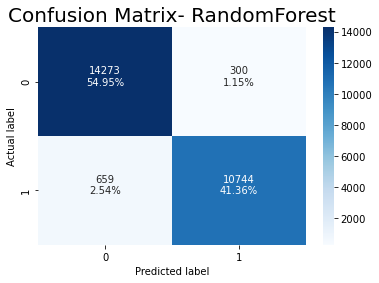

In [121]:
# Visualization of the results
rf_matrix = metrics.confusion_matrix(test_lables,rand_second_pred)
create_matrix(rf_matrix, 'RandomForest')

In [122]:
precision = precision_score(test_lables,rand_second_pred)
recall = recall_score(test_lables,rand_second_pred)
f1 = f1_score(test_lables,rand_second_pred)
print("Precision = ",precision)
print('Recall = ',recall)
print('F1 score =',f1)

Precision =  0.9728359290112278
Recall =  0.9422081908269754
F1 score = 0.9572771417115873


**After performing gridsearchCV optimization, we didn't notice performance improvement (F1 score stayed 0.957).**

## 4.MLP Classifier

**We again use the same features used in the previous classifier as they proved very usefull and yielded high performance**

First try - without GridsearchCV optimization

In [124]:
# Build and train the model without optimization
mlp_first =  MLPClassifier(random_state=SEED)
mlp_first.fit(train_x, train_y)

# Predict the response for test dataset
mlp_first_pred = mlp_first.predict(to_predict)

In [125]:
acc=metrics.accuracy_score(test_lables, mlp_first_pred)
print("The accuracy of Neural net Multi-layer Perceptron with almost all features model without gridSearch optimization: ",acc)
print("Meaning,",round(acc*100,2),"% of the samples were classified correctly")

The accuracy of Neural net Multi-layer Perceptron with almost all features model without gridSearch optimization:  0.9603865106251925
Meaning, 96.04 % of the samples were classified correctly


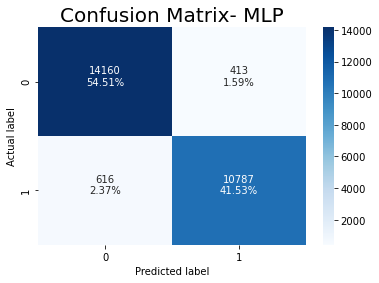

In [126]:
# Visualization of the results
mlp_matrix = metrics.confusion_matrix(test_lables,mlp_first_pred)
create_matrix(mlp_matrix, 'MLP')

In [127]:
precision = precision_score(test_lables,mlp_first_pred)
recall = recall_score(test_lables,mlp_first_pred)
f1 = f1_score(test_lables,mlp_first_pred)
print("Precision = ",precision)
print('Recall = ',recall)
print('F1 score =',f1)

Precision =  0.963125
Recall =  0.9459791282995703
F1 score = 0.9544750696810159


**We note that the MLP classifier perfromance were a bit lower than the Random Forest (F1 score: 0.957->0.954), although its recall score is a bit higher (0.942->0.945) than Random forest, the precision dropped (0.974->0.963) by a bit higher rate, and therefore the overall F1 score is a bit lower.<br>
Next, we add gridsearch optimization.**

In [129]:
# Build the MLP model
mlp = MLPClassifier(random_state=SEED)

# Optimization to the model
mlp_param_grid = {
                'max_iter':[200,400,800],
                'activation':['identity', 'logistic', 'tanh', 'relu'],
                'n_iter_no_change':[10,15] }

gs_mlp = GridSearchCV(mlp, param_grid = mlp_param_grid, cv=5, scoring="accuracy", n_jobs= -1)

# Train the model
gs_mlp.fit(train_x, train_y)

# Predict the response for test dataset
mlp_second_pred = gs_mlp.predict(to_predict)

In [130]:
mlp_second = gs_mlp.best_estimator_
print("Best Parameters:\n", gs_mlp.best_params_)

Best Parameters:
 {'activation': 'logistic', 'max_iter': 200, 'n_iter_no_change': 15}


In [133]:
acc=metrics.accuracy_score(test_lables, mlp_second_pred)
print("The accuracy of Random Forest with almost all features model without gridSearch optimization: ",acc)
print("Meaning,",round(acc*100,2),"% of the samples were classified correctly")

The accuracy of Random Forest with almost all features model without gridSearch optimization:  0.9595010779180783
Meaning, 95.95 % of the samples were classified correctly


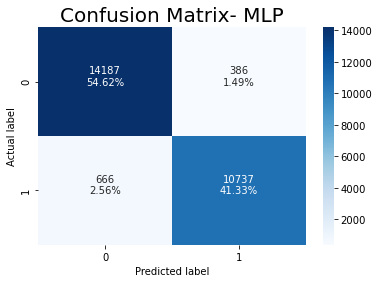

In [134]:
# Visualization of the results
mlp_matrix = metrics.confusion_matrix(test_lables,mlp_second_pred)
create_matrix(mlp_matrix, 'MLP')

In [135]:
precision = precision_score(test_lables,mlp_second_pred)
recall = recall_score(test_lables,mlp_second_pred)
f1 = f1_score(test_lables,mlp_second_pred)
print("Precision = ",precision)
print('Recall = ',recall)
print('F1 score =',f1)

Precision =  0.9652971320686865
Recall =  0.941594317284925
F1 score = 0.953298410725384


**We again see that the gridsearch optimization did not improve the performance (F1 score: 0.954->0.953).**

## 3.XGBoost Classifier

In [136]:
# Build and train the model without optimization
xgb_first = XGBClassifier(eval_metric='logloss',random_state=SEED)
xgb_first.fit(train_x, train_y)

# Predict the response for test dataset
xgb_first_pred = xgb_first.predict(to_predict)

In [137]:
acc=metrics.accuracy_score(test_lables, xgb_first_pred)
print("The accuracy of XGBoost with almost all features model without gridSearch optimization: ",acc)
print("Meaning,",round(acc*100,2),"% of the samples were classified correctly")

The accuracy of XGBoost with almost all features model without gridSearch optimization:  0.9627733292269788
Meaning, 96.28 % of the samples were classified correctly


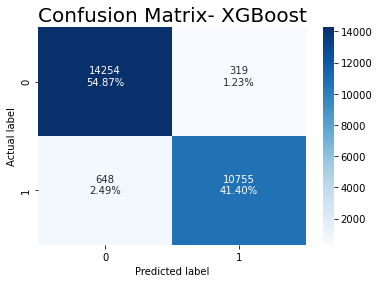

In [139]:
# Visualization of the results
mlp_matrix = metrics.confusion_matrix(test_lables,xgb_first_pred)
create_matrix(mlp_matrix, 'XGBoost')

Text(0.5, 1.0, 'Feature Importance')

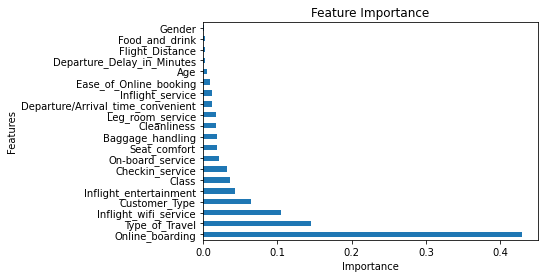

In [142]:
#Display the importance of each feature
feat_importances = pd.Series(xgb_first.feature_importances_, index=to_predict.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance')

**From the Feature Importance analysis we see that online onboarding is the main feature used, we notice that 5 of the 6 main features used by this lassfier are identical to the Random Forest - indicating they are significant features**

In [140]:
precision = precision_score(test_lables,xgb_first_pred)
recall = recall_score(test_lables,xgb_first_pred)
f1 = f1_score(test_lables,xgb_first_pred)
print("Precision = ",precision)
print('Recall = ',recall)
print('F1 score =',f1)

Precision =  0.9711937872494131
Recall =  0.9431728492501973
F1 score = 0.9569782444276372


**We see that the XGBoost classfier yields high performance (very close to the Random Forest which is still the best).
Also like the Random Forest,we see that the algorithm yields higher Precision (0.97) and a bit lower Recall (0.94) and it's derived F1 score is 0.957.**<br>

**This resemblance to the Random forest is not surprising as we saw from the feature Importance, both classifers mainly used same features.**

## Summary of task 5:
**We used several classifiers (AdaBoost,Random Forest,MLP,XGBoost) to try and maximize the problem of satisfaction calssification:**

1. We note that we best results were received when using all the feature and not partial feature set (even if the partial set was estimated to be the most relrevant to satisfaction).<br>
<br>
2. We used Accuracy,Percision,Recall & F1 scores to compare and ecaluate the models, while selected F1 as the main indicator (we chose that since we consider both Percision & Recall equally important).<br>
<br>
3. We saw that generally, all calssfiers performed quite well (recall,precision & F1 scores always higher than 0.91)<br>
<br>
4. The best performance receiuved are (in this order. by F1 scores) Random Forest 0.957, XGBoost ~0.957, MLP 0.954, ADABoost 0.918.<br>
<br>
5. We noticed from the feature importance analysis that Random Forest & XGBoost used mainly the same features so we are not surprised their performance are very close, while ADABoost used different features (mainly 3 compared to 6-7 in Random Forest & XGBoost) and therefore we're not surprised that its performance is less good. 

**In conclusion we think the problem of classification was succesfully maximizes as the classifers yield very high performance.** 

# Task 6
We decide to define the new label by calculating the average of the most correlated original features to satisfaction:
* Online boarding
* Inflight entertainment
* Seat comfort

We chose only 3 features because we learned that we achieve high accruacy by using many features (according to the last task).

**First, we set the type of new label as ordinal (ordinal categories 0-5), since we base our new label on ordinal features therefore we decided to create the label accordingly as a ordinal label.** 

In [299]:
# Create the new label with the chosen features at train dataset
chosen_features = ["Online_boarding", "Seat_comfort", "Inflight_entertainment"]
df_create_label = df_train[chosen_features].copy()
df_create_label['new_satisfaction'] = round((df_create_label['Online_boarding'] + df_create_label['Seat_comfort'] + 
df_create_label['Inflight_entertainment']) / 3)

# Create the new label with the chosen features at test dataset
df_test_create_label = df_test[chosen_features].copy()
df_test_create_label['new_satisfaction'] = round((df_test_create_label['Online_boarding'] + df_test_create_label['Seat_comfort'] + 
df_test_create_label['Inflight_entertainment']) / 3)

In [300]:
df_create_label.sample(5)

Online_boarding  Seat_comfort  Inflight_entertainment  new_satisfaction
92855                2             3                       4               3.0
66506                5             5                       3               4.0
9861                 5             1                       1               2.0
83030                0             3                       3               2.0
21900                3             3                       4               3.0

**In this task, we will try to predict the 'satisfaction value' by using 2 different regression models.<br>
At this section,our training set (X_train) does not include the features which were used to create the labels.**

In [301]:
# Preparing the data for the task by dividing it to appropriate sets 
train_x_new = df_train.drop(columns=["Online_boarding", "Seat_comfort", "Inflight_entertainment","satisfaction"], axis=1)
# df_create_label['new_satisfaction'] = df_create_label['new_satisfaction'].astype(int)
train_y_new = df_create_label['new_satisfaction'] 

to_predict_new = df_test.drop(columns=["Online_boarding", "Seat_comfort", "Inflight_entertainment","satisfaction"], axis=1)
# df_test_create_label['new_satisfaction'] = df_test_create_label['new_satisfaction'].astype(int)
test_lables_new = df_test_create_label['new_satisfaction']

# For storing the results from the models
mse = []
r2 = []
evs = []

# 1.AdaBoost Regressor

In [302]:
# Build the AdaBoost model 
adab_reg = AdaBoostRegressor()

# Optimization to the model
params = {
         'n_estimators': [30,50,70,90],
         'learning_rate' : [0.1, 0.5, 1],
         'loss' : ['linear', 'square', 'exponential'] }

random = RandomizedSearchCV(adab_reg, params, random_state=SEED)
search = random.fit(train_x_new, train_y_new)

# Create new model according to the best parameters we got
estim = search.best_estimator_
ada_best = AdaBoostRegressor(estim)

# Train the model
ada_best.fit(train_x_new, train_y_new)

# Predict the response for test dataset
y_pred_adab_reg = ada_best.predict(to_predict_new)

In [303]:
mean_sq = mean_squared_error(test_lables_new, y_pred_adab_reg)
score = r2_score(test_lables_new, y_pred_adab_reg)
variance = explained_variance_score(test_lables_new, y_pred_adab_reg)
mse.append(mean_sq)
r2.append(score)
evs.append(variance)
print("The mean squared error: " ,mean_sq)
print("The R2 score is: " ,score)
print("The explained variance: ", variance)

The mean squared error:  0.4508404882930393
The R2 score is:  0.6244550922052987
The explained variance:  0.631541989248402


# 2. RandomForest Regressor

In [304]:
# Build the RandomForest model 
rand_reg = RandomForestRegressor()

# Optimization to the model
params_rand = {
        'n_estimators':[50,100,150,200],  
        'criterion': ['mse', 'mae'],
        'random_state': SEED }

random = RandomizedSearchCV(rand_reg, params_rand)
search = random.fit(train_x_new, train_y_new)

# Create new model according to the best parameters we got
estim = search.best_estimator_
rand_best = RandomForestRegressor(estim)

# Train the model
rand_best.fit(train_x_new, train_y_new)

# Predict the response for test dataset
y_pred_rand_reg = rand_best.predict(to_predict_new)

In [305]:
mean2_sq = mean_squared_error(test_lables_new, y_pred_rand_reg)
score2 = r2_score(test_lables_new, y_pred_rand_reg)
variance2 = explained_variance_score(test_lables_new,  y_pred_rand_reg)
mse.append(mean2_sq)
r2.append(score2)
evs.append(variance2)
print("The mean squared error: " ,mean2_sq)
print("The R2 score is: " ,score2)
print("The explained variance: ", variance2)

The mean squared error:  0.20530611975798171
The R2 score is:  0.8289823788761309
The explained variance:  0.8290654111295899


### Comparison between the models
We will compare the models according to 3 different measures:
* **$MSE$** - $Mean Squared Error$ - indicates the average error (distance of the predicted points from the regression line, the more shorter the distance - the more accurate the model (lower values indicate higher accuracy)
* **$R2$** - (coefficient of determination) regression score function, as the value will be higher (best possible score is 1.0) it's means the model more accurate.
* **$EVS$** - explained variance score function, values range from 0 to 1 and max score is 1.0, lower values are worse, which means higher value - more accurate model.

In [306]:
# Create DataFrame with the results
data = {'Model': ['AdaBoost','RandomForest'],
         'MSE' : mse,
         'R2': r2,
         'EVS': evs }
  
# Display the results at table
df_comparison = pd.DataFrame(data)
df_comparison

Model       MSE        R2       EVS
0      AdaBoost  0.450840  0.624455  0.631542
1  RandomForest  0.205306  0.828982  0.829065

Text(0.5, 1.0, 'Model Comparison - Ordinal Label')

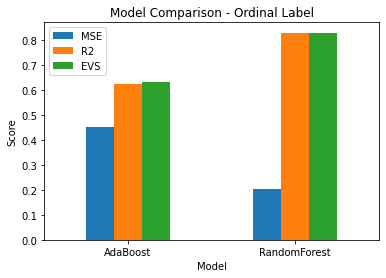

In [307]:
df_comparison.plot.bar(x='Model',rot=0)
plt.ylabel('Score')
plt.title('Model Comparison - Ordinal Label')

### Analysis:
* As can be seen from the table and graph, "RandomForest" yielded better results. 
* The R2 and EVS are significally higher than AdaBoost, in addition we can see that RandomForest had a lower MSE score which means that this model was more accurate and close to the actual labels.
* the fact that the random forest performed better is not surprising as we saw already on task 5 that the random forest performed better as classfier than AdaBoost.

**Next, we will create our label as float (continuous value) in order to check if the rounding of the results earlier decreased the accuracy.<br>
We expect to see improved results since the values of the labels is not mutated by rounding it.**

In [308]:
# Create the new label - continuous value 
df_create_label['continuous_satisfaction'] = (df_create_label['Online_boarding'] + df_create_label['Seat_comfort'] + 
df_create_label['Inflight_entertainment']) / 3

df_test_create_label['continuous_satisfaction'] = (df_test_create_label['Online_boarding'] + df_test_create_label['Seat_comfort'] + 
df_test_create_label['Inflight_entertainment']) / 3

In [309]:
# Changing only train labels and test labels because the train\test X has not changed
train_y_continuous = df_create_label['continuous_satisfaction'] 

test_lables_continuous = df_test_create_label['continuous_satisfaction']

# For storing the results from the models
mse_second = []
r2_second = []
evs_second = []

# 1b.AdaBoost Regressor


In [310]:
# Build the RandomForest model 
adab2_reg = AdaBoostRegressor()

# Optimization to the model
params2 = {
         'n_estimators': [30,50,70,90],
         'learning_rate' : [0.1, 0.5, 1],
         'loss' : ['linear', 'square', 'exponential'] }

random = RandomizedSearchCV(adab2_reg, params2, random_state=SEED)
search = random.fit(train_x_new, train_y_continuous)

# Create new model according to the best parameters we got
estim = search.best_estimator_
ada2_best = AdaBoostRegressor(estim)

# Train the model
ada2_best.fit(train_x_new, train_y_continuous)

# Predict the response for test dataset
y_pred2_adab_reg = ada2_best.predict(to_predict_new)

In [311]:
mean2_sq = mean_squared_error(test_lables_continuous, y_pred2_adab_reg)
score2 = r2_score(test_lables_continuous, y_pred2_adab_reg)
variance2 = explained_variance_score(test_lables_continuous, y_pred2_adab_reg)
mse_second.append(mean2_sq)
r2_second.append(score2)
evs_second.append(variance2)
print("The mean squared error: " ,mean2_sq)
print("The R2 score is: " ,score2)
print("The explained variance: ", variance2)

The mean squared error:  0.40236648303215744
The R2 score is:  0.6396936328166154
The explained variance:  0.6519986430397187


# 2b. RandomForest Regressor

In [312]:
# Build the RandomForest model 
rand2_reg = RandomForestRegressor()

# Optimization to the model
params2_rand = {
        'n_estimators':[50,100,150,200],  
        'criterion': ['mse', 'mae'],
        'random_state': [SEED] }

random = RandomizedSearchCV(rand2_reg, params2_rand)
search = random.fit(train_x_new, train_y_continuous)

# Create new model according to the best parameters we got
estim = search.best_estimator_
rand2_best = RandomForestRegressor(estim)

# Train the model
rand2_best.fit(train_x_new, train_y_continuous)

# Predict the response for test dataset
y_pred2_rand_reg = rand2_best.predict(to_predict_new)

In [313]:
mean2_sq = mean_squared_error(test_lables_continuous, y_pred2_rand_reg)
score2 = r2_score(test_lables_continuous, y_pred2_rand_reg)
variance2 = explained_variance_score(test_lables_continuous,  y_pred2_rand_reg)
mse_second.append(mean2_sq)
r2_second.append(score2)
evs_second.append(variance2)
print("The mean squared error: " ,mean2_sq)
print("The R2 score is: " ,score2)
print("The explained variance: ", variance2)

The mean squared error:  0.15065456616898507
The R2 score is:  0.865093635466656
The explained variance:  0.8651969580970647


### Comparison between the models
We will compare the models according the same measures like before, the difference is the label- previously, the models predicted the ordinal label and now the prediction is based on continuous values. <br>

In [314]:
# Create DataFrame with the results
data2 = {'Model': ['AdaBoost','RandomForest'],
         'MSE' : mse_second,
         'R2': r2_second,
         'EVS': evs_second }
  
# Display the results at table
df2_comparison = pd.DataFrame(data2)
df2_comparison

Model       MSE        R2       EVS
0      AdaBoost  0.402366  0.639694  0.651999
1  RandomForest  0.150655  0.865094  0.865197

Text(0.5, 1.0, 'Model Comparison Continuous Label')

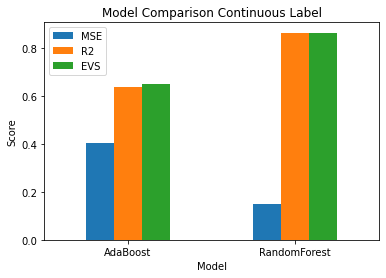

In [315]:
df2_comparison.plot.bar(x='Model',rot=0)
plt.ylabel('Score')
plt.title('Model Comparison Continuous Label')

### Analysis:
As can be seen from the table and graph, as expected, both models performed better when values are not rounded - yielded higher accuracy. <br>
In both models the R2 and EVS increased, and the MSE is lower - which means the models accuracy imporved.<br>

**Next, we repeat the process, this time we will try to predict the continuous label (which yielded better results) of same data but now we also add the feature from which we created our new labels, by adding those , we expect an increase in the performance (better accuracy , lower errors).**

In [316]:
# Prepering the train X with the chosen features
# The labels stay the same
train_x_chosen_features = df_train.drop(columns=["satisfaction"], axis=1)
to_predict_with = df_test.drop(columns=["satisfaction"], axis=1)

mse_with = []
r2_with = []
evs_with = []

# 1c.AdaBoost Regressor

In [317]:
# Build the RandomForest model 
adab3_reg = AdaBoostRegressor()

# Optimization to the model
params3 = {
         'n_estimators': [30,50,70,90],
         'learning_rate' : [0.1, 0.5, 1],
         'loss' : ['linear', 'square', 'exponential'] }

random = RandomizedSearchCV(adab3_reg, params3, random_state=SEED)
search = random.fit(train_x_chosen_features, train_y_continuous)

# Create new model according to the best parameters we got
estim = search.best_estimator_
ada3_best = AdaBoostRegressor(estim)

# Train the model
ada3_best.fit(train_x_chosen_features, train_y_continuous)

# Predict the response for test dataset
y_pred3_adab_reg = ada3_best.predict(to_predict_with)

In [318]:
mean3_sq = mean_squared_error(test_lables_continuous, y_pred3_adab_reg)
score3 = r2_score(test_lables_continuous, y_pred3_adab_reg)
variance3 = explained_variance_score(test_lables_continuous, y_pred3_adab_reg)
mse_with.append(mean3_sq)
r2_with.append(score3)
evs_with.append(variance3)
print("The mean squared error: " ,mean3_sq)
print("The R2 score is: " ,score3)
print("The explained variance: ", variance3)

The mean squared error:  0.026751699100683476
The R2 score is:  0.976044705696374
The explained variance:  0.9782876480487669


Text(0.5, 1.0, 'Feature Importance- AdaBoost With Features')

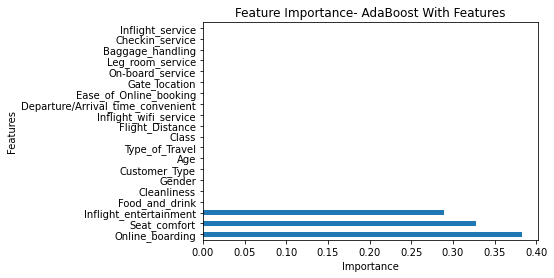

In [319]:
#Display the importance of each feature
feat_importances = pd.Series(ada3_best.feature_importances_, index=to_predict_with.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance- AdaBoost With Features')

Text(0.5, 1.0, 'Feature Importance- AdaBoost WithOut The Features')

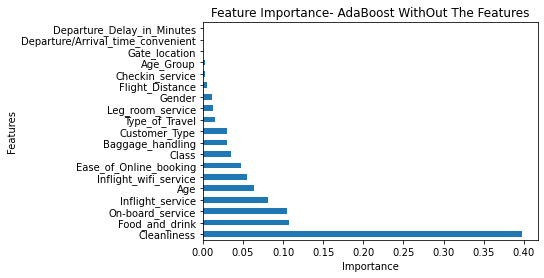

In [320]:
#Display the importance of each feature
feat_importances = pd.Series(ada2_best.feature_importances_, index=to_predict_new.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance- AdaBoost WithOut The Features')

# 2c. RandomForest Regressor

In [321]:
# Build the RandomForest model 
rand3_reg = RandomForestRegressor()

# Optimization to the model
params3_rand = {
        'n_estimators':[50,100,150,200],  
        'criterion': ['mse', 'mae'],
        'random_state': SEED }

random = RandomizedSearchCV(rand3_reg, params3_rand)
search = random.fit(train_x_chosen_features, train_y_continuous)

# Create new model according to the best parameters we got
estim = search.best_estimator_
rand3_best = RandomForestRegressor(estim)

# Train the model
rand3_best.fit(train_x_chosen_features, train_y_continuous)

# Predict the response for test dataset
y_pred3_rand_reg = rand3_best.predict(to_predict_with)

In [322]:
mean3_sq = mean_squared_error(test_lables_continuous, y_pred3_rand_reg)
score3 = r2_score(test_lables_continuous, y_pred3_rand_reg)
variance3 = explained_variance_score(test_lables_continuous,  y_pred3_rand_reg)
mse_with.append(mean3_sq)
r2_with.append(score3)
evs_with.append(variance3)
print("The mean squared error: " ,mean3_sq)
print("The R2 score is: " ,score3)
print("The explained variance: ", variance3)

The mean squared error:  5.149197549875104e-06
The R2 score is:  0.9999953890576344
The explained variance:  0.9999953893068354


Text(0.5, 1.0, 'Feature Importance- RandomForest With Features')

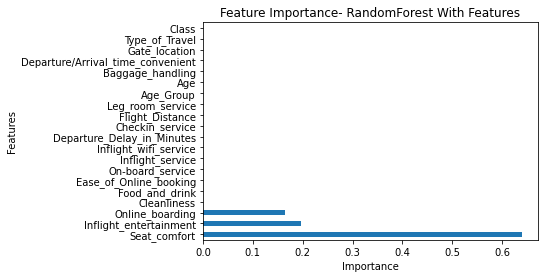

In [323]:
#Display the importance of each feature
feat_importances = pd.Series(rand3_best.feature_importances_, index=to_predict_with.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance- RandomForest With Features')

Text(0.5, 1.0, 'Feature Importance- RandomForest WithOut The Features')

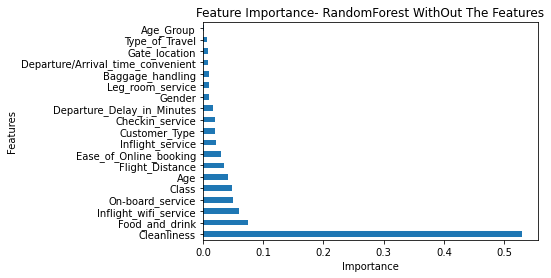

In [324]:
#Display the importance of each feature
feat_importances = pd.Series(rand2_best.feature_importances_, index=to_predict_new.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importance- RandomForest WithOut The Features')

### Analysis:
- We note that in both models which did not include the features from which we created the new labels - the most significant feature (according to the feature importance) was 'cleanlinness' which was a bit surprising as there are other features which have more corrlation to satisfaction than 'cleanliness'

- In both models which included the features we used to create the new label, we saw from the feature importance that only those feature which werre used to create the new label were significant and all the rest were not used by the model.<br>
We expected that these features will be important but the fact that they were the only significant features was surprising to us. In each of the 2 models, the most important feature was different: "Online_boarding" in Adaboost and "Seat_comfort" in Random Forest. <br>
We were suprised as the Adaboost used the most correlated feature from the correlation matrix but still had lower performance compared to the random forest which used a less correlated feature (according to the corrleation matrix)

In [325]:
# Create DataFrame with the results
data3 = {'Model': ['AdaBoost','RandomForest'],
         'MSE' : mse_with,
         'R2': r2_with,
         'EVS': evs_with }
  
# Display the results at table
df3_comparison = pd.DataFrame(data3)
df3_comparison

Model       MSE        R2       EVS
0      AdaBoost  0.026752  0.976045  0.978288
1  RandomForest  0.000005  0.999995  0.999995

Text(0.5, 1.0, "Model Comparison With Label's Features Included")

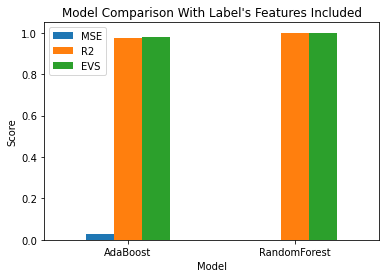

In [326]:
df3_comparison.plot.bar(x='Model',rot=0)
plt.ylabel('Score')
plt.title('Model Comparison With Label\'s Features Included')

**In conclusion, after adding the features from which we created the new label, the performance of the model imporved as expected. However, we were surprised by the magnitude of the improvement which increased very highly (more than we expected).**

# Task 7

**We will summarize and compare all the results received in previous tasks.**

## 1. Summary of visualizations  (dimension reduction techniques):

In [157]:
pd.set_option('display.max_colwidth', None)

In [159]:
data = {'Model': ['t-SNE','PCA','SOM'], 'usefulness(0-5)': ['3', '4', '2'],'Comments': ['Visualization   yield clear clusters with only moderate success',
                                                                                        'Tehnique proved useful in explaining features which explain most of the variance',
                                                                                       'The generated Heatmap could not describe clearly the satisfaction clusters']}
df_visu = pd.DataFrame.from_dict(data)
df_visu

Model usefulness(0-5)  \
0  t-SNE               3   
1    PCA               4   
2    SOM               2   

                                                                           Comments  
0                   Visualization   yield clear clusters with only moderate success  
1  Tehnique proved useful in explaining features which explain most of the variance  
2        The generated Heatmap could not describe clearly the satisfaction clusters

**Comparison Summary:**
--------------------------------------------------------

* **t-SNE** - After trying several hyper parameters combinatations of perplexity,n_iter=500 and even exageration we see from the diagram that clusters are not that coherent and homogenous, we suspect that t-SNE is a model which requries a very delicate selection of hyper parameters and optimization, since the runtime of each t-SNE iteration is very long (hours) we did our best but further optimization may be required.<br>
<br>
* **PCA** - we can see the 2 clusters (red - not satisfied, green - satisfied),<br>
we notice that the clusters are very dense and close to each other, indicating that the clusters differences are not very clear and obvious.<br>
This is not surprising as we saw that our features are not very well correlated to the satisfaction and PC1-PC3 reflect only 45% od the variance related to these features.


* **SOM** - The dark nodes incdicate areas where neighbouring nodes are relatively close to each other and therefore might suggest a cluster.
    * The white nodes indicate areas where neighboring nodes are relatively far from each other and therefore reflect areas of sepreation between the clusters (which are black)

    * As can be seen, there are no clear seperate 2 clusters which might clearly reflect the satisfaction (0/1) although we do seen areas which are more dark (top right zone, bottom left zone) and more white (top left zone,bottom right zone) 

    * Possible reasons for the ambiguous results:
     - The SOM analysis was perform on a 10000 size sample of the dataset which not necessarily represents the entire dataset reliably. 
     - It is possible that the model could have been further optimze by selecting different hyper parameters (we chose several combination but displayed only the best execution)

## 2. Summary of clustering models:

In [162]:
data = {'Model': ['KMeans','Agglomerative'], 'Siluette score': ['0.179', '0.252'],'Main Reason For Use': ['Assumed spheric variance & rougly same size of clusters',
                                                                                                         'Informative,dendogram can provide insights,no need to pre select clusters number']}
df_clust = pd.DataFrame.from_dict(data)
df_clust

Model Siluette score  \
0         KMeans          0.179   
1  Agglomerative          0.252   

                                                                Main Reason For Use  
0                           Assumed spheric variance & rougly same size of clusters  
1  Informative,dendogram can provide insights,no need to pre select clusters number

**Comparison Summary:**
-------------------------------------
* **KMeans** - We used Kmeans as we observed pretty equal variance in all features during our data exploration in task 2-3, further support for using KMeans is that from our check (again in the exploration phase, we concluded that both satisfaction clusters (satisfied/not satisfied) are quite equal in size. However, KMeans clustering provide only average results this was demonstrated by the not very high Siluette score (0.179)<br>
<br>
* **Agglomerative** - We used Aggloerative as this is very informative (we used its dendogram) and have good visualization which we hope will provide us with insights. moreover, this models doesn't require us to preselect the number of clusters, so it provides good confirmation that selecting 2 clusters is a good choice. the model yielded slightly better results than KMeans but still quite average only (Siluette score - 0.252)


## 3. Summary of classfication models:

In [174]:
data = {'Model': ['ADABoost','Random Forest','MLP','XGBoost'],
        'Accuracy':[0.924,0.963,0.960,0.962], 
        'Recall': [0.911, 0.942,0.945,0.945],
        'Precision': [0.924,0.974,0.965,0.971],
        'F1_Score':[0.918,0.957,0.954,0.956]}
df_clust = pd.DataFrame.from_dict(data)
df_clust

Model  Accuracy  Recall  Precision  F1_Score
0       ADABoost     0.924   0.911      0.924     0.918
1  Random Forest     0.963   0.942      0.974     0.957
2            MLP     0.960   0.945      0.965     0.954
3        XGBoost     0.962   0.945      0.971     0.956

**Comparison Summary:**
-------------------------------------

* We can see that all 4 classifiers performs quite well (above 0.911 on all type of measures).
* We can see the Random Forest has the best performance in terms of F1 which is our indicator.
* We can see that for each classifier, the Precsion is a  bit higher than the recall, meaning, the models slightly preforms 
better in minimizing FP (False positives - passangers who were classified as satisfied but are not) than FN (False positives - passangers who were classified as not satisfied and are acttually satisfied)

**Furthur visualization of the comparison can be seen in the barplot below:**

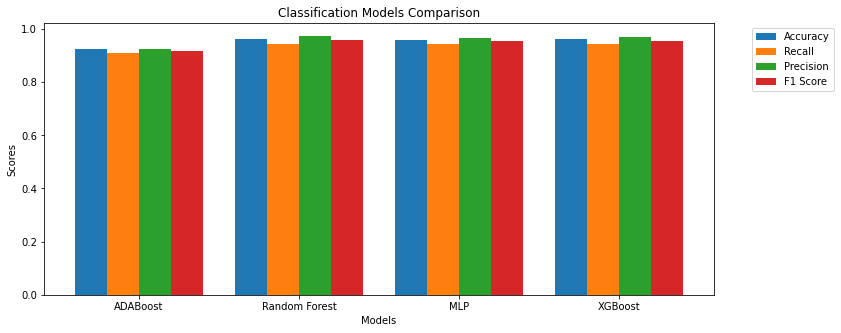

In [274]:
X = df_clust.Model
accuracy = df_clust.Accuracy
recall = df_clust.Recall
precision = df_clust.Precision
f1 = df_clust.F1_Score
  
X_axis = np.arange(len(X))

fig, ax = plt.subplots(figsize=(12, 5))

rects1 =plt.bar(X_axis - 0.3, accuracy, 0.2, label = 'Accuracy')
rects2 =plt.bar(X_axis - 0.1 , recall, 0.2, label = 'Recall')
rects3 =plt.bar(X_axis + 0.1, precision, 0.2, label = 'Precision')
rects4 =plt.bar(X_axis + 0.3, f1, 0.2, label = 'F1 Score')


plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Classification Models Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Regression Models Comparison  with new created label

* We first created the new label from 3 features:<br>"Online_boarding", "Seat_comfort", "Inflight_entertainment"

* for each model we measured the following values:
 - MSE
 - R2
 - EVS 
* We then trained the 2 models (AdaBoost,Random Forest) on all the features besides these 3 and received the following results:

**First test:**<br>
We calculated the average of these features and round the results to create integer values (ordinal label 0-5).**

In [346]:
df_comparison

Model       MSE        R2       EVS
0      AdaBoost  0.450840  0.624455  0.631542
1  RandomForest  0.205306  0.828982  0.829065

As can be seen from the table, the Random Forest regressor yield better results.

**Second test:**<br>
We calculated the average of the 3 features and didn't round the results to continuous (float) values in range (0-5).**

In [348]:
df2_comparison

Model       MSE        R2       EVS
0      AdaBoost  0.402366  0.639694  0.651999
1  RandomForest  0.150655  0.865094  0.865197

Again the Random forest yielded the best results, we saw an improvement in the performance in each of the models, we relate this improvement to the fact that the labels were continous and closer to the real values of the features from which it was created.

**Third test:**
* In this test we trained the 2 models (AdaBoost,Random Forest) using the 3 features from which our new label was created (in addition to all other features)
* Here we used only the continuous (float) labels as they yielded the best results on previous test.
* we received the following results

In [349]:
df3_comparison

Model       MSE        R2       EVS
0      AdaBoost  0.026752  0.976045  0.978288
1  RandomForest  0.000005  0.999995  0.999995

As expected, the results improved when training the models and including the features from which the new labels was created.Again the Random Forest was the better models, as in previous tests.<br> However, we were a bit surprised by the size of improvement in both models, the results got closed to nearly perfect accuracy scores.